In [1]:
!pip install fuzzywuzzy geopy thefuzz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 11.4 MB/s eta 0:00:00


In [2]:
import pandas as pd
import json
import numpy as np
import ast
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import euclidean_distances
import re
from pandas.api.types import CategoricalDtype
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sentence_transformers import SentenceTransformer
from datetime import datetime
from fuzzywuzzy import process

/usr/local/lib/python3.11/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [3]:
with open('appraisals_dataset.json', 'r') as f:
  data = json.load(f)
  df = pd.DataFrame(data)
  df = pd.json_normalize(df['appraisals'])
df

,orderID,comps,properties,subject.address,subject.subject_city_province_zip,subject.effective_date,subject.municipality_district,subject.site_dimensions,subject.lot_size_sf,subject.units_sq_ft,...,subject.room_count,subject.num_beds,subject.room_total,subject.main_lvl_area,subject.second_lvl_area,subject.third_lvl_area,subject.gla,subject.subject_age,subject.num_baths,subject.condition
0,4762597,"[{'distance_to_subject': '0.15 KM', 'prop_type...","[{'id': 367, 'address': '463 Conservatory Dr',...",142-950 Oakview Ave Kingston ON K7M 6W8,"""Twin Oak Meadows""",Apr/11/2025,Kingston,Condo Common Property,n/a,SqFt,...,6,3,6,522,522,,1044,49,1:1,Average
1,4762739,"[{'distance_to_subject': '3.73 KM', 'prop_type...","[{'id': 297301, 'address': '638 Myers Point Ro...",7180 207 HWY Halifax NS B0J2L0,"West Chezzetcook, NS B0J2L0",Apr/17/2025,Halifax Regional Municipality - West Chezzetcook,See Schedule A and or Plot Map,72745+/-SqFt,SqFt,...,6,3,6,1060,440,,1500 SqFt,14+/-yrs,2:1,Average
2,4763065,"[{'distance_to_subject': '0.31 KM', 'prop_type...","[{'id': 116134, 'address': '246 Waterbrook Lan...",11 PAUL AVE Ayr ON N0B1E0,Ayr ON N0B1E0,May/01/2025,"Township of North Dumfries, Region of Waterloo",131' x 154',20174 SqFt,SqFt,...,9,4,9,1660,1340,,3000 SqFt,42,2:1,Average
3,4763086,"[{'distance_to_subject': '0.78 KM', 'prop_type...","[{'id': 1849, 'address': '501 CLOTHIER Street ...",102 Stonewalk Dr Kemptville ON K0G 1J0,Kemptville ON K0G 1J0,Apr/15/2025,"North Grenville, Ontario",176.38 F x Irregular,1.25 Acres,Acres,...,5,2,5,,,,1283 SqFt,2012 +/-,3:0,Good
4,4763087,"[{'distance_to_subject': '0.00 KM', 'prop_type...","[{'id': 293769, 'address': '3 Apollo Court', '...",407 105 Dunbrack St Halifax NS B3M3G7,Halifax NS B3M3G7,Apr/17/2025,Halifax Regional Municipality - Halifax,CONDO - N/A,N/A,N/A,...,6,3,6,1530,,,1530 SqFt,47+/-yrs,2:0,Average
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,4778326,"[{'distance_to_subject': '0.47 KM', 'prop_type...","[{'id': 12120, 'address': '163 Hidden Valley M...",184 Sandpiper Cir NW Calgary AB T3K3P4,Calgary AB T3K3P4,May/05/2025,"Calgary, AB / Sandstone Valley",10.05m x 45.23m,759 SqM,SqM,...,7,3,7,1045.37,701.43,,1746.79 SqFt,1988,2F 1H,Good
84,4758996,"[{'distance_to_subject': '0.03 KM', 'prop_type...","[{'id': 10480, 'address': '10 Tipping Close SE...",160 Marquis Pl SE Airdrie AB T4A1Y7,Airdrie AB T4A1Y7,Apr/09/2025,"Airdrie, AB / Meadowbrook",14.32m x 37.80m,541 SqM,SqM,...,6,3,6,,,,1144 SqFt,1979,1F 1H,Average
85,4775785,"[{'distance_to_subject': '4.67 KM', 'prop_type...","[{'id': 22737, 'address': '4232 Camden Portlan...",1841 Fisk Rd Odessa ON K0H2H0,Odessa ON K0H2H0,Apr/30/2025,"Loyalist Township, County of Lennox and Addington",830' x Irregular,10 Acres,Acres,...,10,5,10,1517,621,,"2,138 SqFt",125,2:0,Average
86,4775292,"[{'distance_to_subject': '16.85 KM', 'prop_typ...","[{'id': 178462, 'address': '6135 Second Line '...",64232 COUNTY RD 3 East Garafraxa ON L9W7J4,East Garafraxa ON L9W7J4,May/02/2025,"Township of East Garafraxa, County of Dufferin",223.32' x 1966.85',10 Acres,Acres,...,10,5,10,2250,,,2250 SqFt,48,3:0,Average


In [4]:
print(df.shape)
print(df.columns)

(88, 38)
Index(['orderID', 'comps', 'properties', 'subject.address',
       'subject.subject_city_province_zip', 'subject.effective_date',
       'subject.municipality_district', 'subject.site_dimensions',
       'subject.lot_size_sf', 'subject.units_sq_ft', 'subject.year_built',
       'subject.structure_type', 'subject.roofing', 'subject.effective_age',
       'subject.style', 'subject.construction',
       'subject.remaining_economic_life', 'subject.windows',
       'subject.basement', 'subject.exterior_finish', 'subject.basement_area',
       'subject.foundation_walls', 'subject.flooring',
       'subject.plumbing_lines', 'subject.heating', 'subject.fuel_type',
       'subject.water_heater', 'subject.cooling', 'subject.room_count',
       'subject.num_beds', 'subject.room_total', 'subject.main_lvl_area',
       'subject.second_lvl_area', 'subject.third_lvl_area', 'subject.gla',
       'subject.subject_age', 'subject.num_baths', 'subject.condition'],
      dtype='object')


## Data Cleaning Pipeline

In [5]:
# Check the shape of the DataFrame
print(f"DataFrame shape: {df.shape}")

# Identify missing values
print("\nMissing Values:")
print(df.isnull().sum())

#Property example
print("\nProperty Example:")
print(df['properties'][0])

print("\Comp Example:")
print(df['comps'][0])

DataFrame shape: (88, 38)

Missing Values:
orderID                              0
comps                                0
properties                           0
subject.address                      0
subject.subject_city_province_zip    0
subject.effective_date               0
subject.municipality_district        1
subject.site_dimensions              0
subject.lot_size_sf                  0
subject.units_sq_ft                  1
subject.year_built                   1
subject.structure_type               1
subject.roofing                      1
subject.effective_age                1
subject.style                        0
subject.construction                 1
subject.remaining_economic_life      1
subject.windows                      1
subject.basement                     0
subject.exterior_finish              1
subject.basement_area                1
subject.foundation_walls             1
subject.flooring                     1
subject.plumbing_lines               1
subject.heating      

In [6]:
properties_df = pd.DataFrame(df['properties'][1])
display(properties_df)

,id,address,bedrooms,gla,city,province,postal_code,property_sub_type,structure_type,style,...,year_built,roof,basement,cooling,heating,close_price,close_date,public_remarks,latitude,longitude
0,297301,638 Myers Point Road,2,1136,Nova Scotia,Nova Scotia,B0J 1P0,Detached,Single Family,Bungalow,...,2010.0,Asphalt Shingle,"Full, Fully Developed, Walkout","Baseboard, Heat Pump, Fireplace, ETS (Elec The...","Baseboard, Heat Pump, Fireplace, ETS (Elec The...",710000.0,2024-10-30,Welcome to your dream home. It boasts a prime...,44.7765,-63.0424
1,292631,281 West Jeddore Road,3,1026,Nova Scotia,Nova Scotia,B0J 1P0,Detached,Single Family,"Bungalow, 1 Level",...,NaN,Asphalt Shingle,"Undeveloped, Full, Walkout","Stove, Heat Pump, Ductless Cooling","Stove, Heat Pump, Ductless Cooling",450000.0,2024-11-01,"Welcome to 281 West Jeddore Rd., an oceanfront...",44.7683,-63.0714
2,297309,46 Ostrea Lake Road,3,2117,Nova Scotia,Nova Scotia,B0J 2L0,Detached,Single Family,"Bungalow, 2 Level",...,1967.0,Asphalt Shingle,Partially Developed,"Baseboard, Heat Pump, Fireplace","Baseboard, Heat Pump, Fireplace",930000.0,2024-11-01,"For an in-depth look, see it at Realtor.ca and...",44.7809,-63.1032
3,293953,15 Macdonald Lane,2,816,Nova Scotia,Nova Scotia,B0J 2L0,Detached,Single Family,Bungalow,...,2021.0,Asphalt Shingle,None,Baseboard,Baseboard,430000.0,2024-11-08,Seize the opportunity to own a slice of sereni...,44.7889,-63.1428
4,293612,8426 Highway 7,3,1350,Nova Scotia,Nova Scotia,B0J 2L0,Detached,Single Family,2 Level,...,1918.0,Metal,"Undeveloped, Full, Walkout",Forced Air,Forced Air,395000.0,2024-11-28,"Nestled in peaceful Musquodoboit Harbour, this...",44.7903,-63.1199
5,294897,569 West Jeddore Road,3,1320,Nova Scotia,Nova Scotia,B0J 1P0,Detached,Single Family,Bungalow,...,2013.0,Asphalt Shingle,"Undeveloped, Walkout","Baseboard, Heat Pump","Baseboard, Heat Pump",378275.0,2024-12-06,This thoughtfully designed bungalow features a...,44.7584,-63.0603
6,293390,9051 Highway 7,3,1092,Nova Scotia,Nova Scotia,B0J 1P0,Detached,Single Family,Split Entry,...,1995.0,Asphalt Shingle,"Full, Partially Developed, Walkout","Baseboard, Furnace, Forced Air","Baseboard, Furnace, Forced Air",415000.0,2024-12-09,This charming split-entry home offers a perfec...,44.7788,-63.0876
7,292232,6547 Highway 7,3,1100,Nova Scotia,Nova Scotia,B0H 1N0,Detached,Single Family,2 Level,...,1945.0,Metal,Crawl Space,"Furnace, Forced Air","Furnace, Forced Air",420000.0,2024-12-13,Welcome to your dream home! This beautifully r...,44.7648,-63.2169
8,292152,8179 7 Highway,2,1078,Nova Scotia,Nova Scotia,B0J 2L0,Detached,Single Family,1.5 Level,...,NaN,Asphalt Shingle,None,"Baseboard, Heat Pump","Baseboard, Heat Pump",325000.0,2024-12-27,Spend the holidays in your new home! A quick c...,44.7922,-63.1337
9,263677,"205 East Petpeswick Road, Musquodoboit Harbour",2,616,Nova Scotia,Nova Scotia,B0J 2L0,Detached,Detached,Detached,...,1934.0,Asphalt Shingle,None,Furnace,Furnace,135000.0,2025-01-10,Welcome to the Cottage. Perfectly located just...,44.7784,-63.1482


In [7]:
properties_df.columns
#Drop addresss, id, city, province, public_remarks

Index(['id', 'address', 'bedrooms', 'gla', 'city', 'province', 'postal_code',
       'property_sub_type', 'structure_type', 'style', 'levels', 'room_count',
       'full_baths', 'half_baths', 'main_level_finished_area',
       'upper_lvl_fin_area', 'bg_fin_area', 'lot_size_sf', 'year_built',
       'roof', 'basement', 'cooling', 'heating', 'close_price', 'close_date',
       'public_remarks', 'latitude', 'longitude'],
      dtype='object')

In [8]:
for col in df.select_dtypes(exclude=['number']):
  if not (col == "orderID" or col == "comps" or col == "properties"):
    print(f"\nUnique values and frequencies for column '{col}':")
    print(df[col].value_counts())


Unique values and frequencies for column 'subject.address':
subject.address
142-950 Oakview Ave Kingston ON K7M 6W8       1
7180 207 HWY Halifax NS B0J2L0                1
11 PAUL AVE Ayr ON N0B1E0                     1
102 Stonewalk Dr Kemptville ON K0G 1J0        1
407 105 Dunbrack St Halifax NS B3M3G7         1
                                             ..
184 Sandpiper Cir NW Calgary AB T3K3P4        1
160 Marquis Pl SE Airdrie AB T4A1Y7           1
1841 Fisk Rd Odessa ON K0H2H0                 1
64232 COUNTY RD 3 East Garafraxa ON L9W7J4    1
1050 John F. Scott Rd Kingston ON K7L4V3      1
Name: count, Length: 88, dtype: int64

Unique values and frequencies for column 'subject.subject_city_province_zip':
subject.subject_city_province_zip
Kingston ON K7L0G8          3
Kemptville ON K0G 1J0       2
Lowbanks ON N0A1K0          2
"Twin Oak Meadows"          1
Halifax NS B3M3G7           1
                           ..
Calgary AB T3K3P4           1
Airdrie AB T4A1Y7           1
Odes

In [9]:
comps_df = pd.DataFrame(df['comps'][0])
display(comps_df)

,distance_to_subject,prop_type,stories,address,city_province,sale_date,sale_price,dom,location_similarity,lot_size,age,condition,gla,room_count,bed_count,bath_count,basement_finish,parking,neighborhood
0,0.15 KM,Townhouse,2 Storey,930 Amberdale Cres,Kingston ON K7M 6V1,Oct/25/2024,"378,900",38,Similar,N/A Condominium,49,Superior,1044 SqFt,6,3,2:0,Full/Finished,No Garage,
1,0.02 KM,Townhouse,2 Storey,771 Ashwood Dr,Kingston ON K7M 6X7,Feb/05/2025,"327,000",51,Inferior,N/A Condominium,49,Inferior,1044 SqFt,6,3,1:0,Full/Finished,No Garage,
2,0.09 KM,Townhouse,2 Storey,995 Amberdale Cres,Kingston ON K7M 6X6,Feb/14/2025,"315,000",95,Inferior,N/A Condominium,49,Inferior,1044 SqFt,6,3,2:0,Full/Part Finished,No Garage,


In [10]:
df['subject.style'] = df['subject.style'].str.lower().str.strip()
def extract_story_count(style):
    if not style or not isinstance(style, str):
        return None

    style_lower = style.strip().lower()

    # Normalize common variants
    style_lower = style_lower.replace('strorey', 'storey').replace('stories', 'storey').replace('-', ' ').strip()

    # Handle specific known formats
    if style_lower in ['bungalow', 'bungalow raised', 'bi level', 'one level', '1 level', '1 storey']:
        return 1
    if style_lower in ['1.5 storey', '1 1/2 storey']:
        return 2
    if style_lower in ['2 storey', 'two']:
        return 2
    if style_lower == '2.5 storey':
        return 3
    if style_lower == '3 storey':
        return 3
    if style_lower == '3 plus storey':
        return 3
    if style_lower == '4 level split':
        return 4
    if style_lower in ['split level', 'sidesplit', 'sidesplit 3', 'sidesplit 4', 'backsplit 3', 'backsplit 4']:
        match = re.search(r'(\d)', style_lower)
        if match:
            return int(match.group(1))
        return 2  # default to 2 if no number

    if style_lower in ['apartment', 'bachelor/studio', 'other']:
        return None  # No clear story count

    # Try to extract numeric level
    match = re.search(r'\d+(\.\d+)?', style_lower)
    if match:
        num = float(match.group())
        return int(round(num))

    return None

In [11]:
df['story_count'] = df['subject.style'].apply(extract_story_count)

In [12]:
print(df['story_count'].unique())

[2 1 4 3]


In [13]:
print(df['subject.address'].unique())

['142-950 Oakview Ave Kingston ON K7M 6W8'
 '7180 207 HWY Halifax NS B0J2L0' '11 PAUL AVE Ayr ON N0B1E0'
 '102 Stonewalk Dr Kemptville ON K0G 1J0'
 '407 105 Dunbrack St Halifax NS B3M3G7'
 '40 Bellroyal Crt Cole Harbour NS B2V 2B4'
 '10 Crofton Rd Toronto ON M4G2B4'
 '11 Bermondsey Way Stittsville ON K2S2Y7'
 '306 11 SPRINGVALE AVE Halifax NS B3N0A3'
 '229 SANDPIPER CRES Chestermere AB T1X0Y4'
 '164 Redmonds Rd Seabright NS B3Z3C4' '11 Bashir St Maple ON L6A3A3'
 '1368 Shore Dr Bedford NS B4A2E8' '5004 Fox Run Pl Kingston ON K7P0E4'
 '201 Halfway Lake Dr Hammonds Plains NS B4B1M8'
 '5 Golflinks Dr Ottawa ON K2J 4X9'
 '3435 Vandorf Siderd Stouffville ON L4A4H5'
 '118 Colborne St Kingston ON K7K 1C9'
 '92 Armcrest Dr Lower Sackville NS B4C3Z9'
 '1083 Cornerstone St NE Calgary AB T3N1G5'
 '504 37 St NW, Calgary, AB T2N 3B8, Canada'
 '8915 20 Ave SW Edmonton AB T6X2C5'
 '531 Des Genévriers Rue Orléans ON K4A0Z2'
 '2306-530 3 St SE Calgary AB T2G 2L8'
 '405 Allard Blvd SW Edmonton AB T6W3T3

In [14]:
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import re
import time

In [15]:
# "64232 County Road 3 East Garafraxa ON L9W7J4, '60 Mill Lake RD #2 Simms Settlement NS B0J1T0''140 Simcoe Street, Toronto, ON M5H4E9'"
"""-
- 504 37 St NW, Calgary, AB T2N 3B8, Canada -> "504 37 St NW, Calgary, AB T2N 3B8, Canada"
- 1606-730 2 Ave SW Calgary AB T2P 1R8 -> 730 2 Ave SW Calgary AB T2P 1R8
- 84339 Kent Line Brussels ON N0G1H0 -> 84339 Kent Line ON N0G1H0 ->"""
address = "504 37 St NW, Calgary, AB T2N 3B8, Canada"
geolocator = Nominatim(user_agent="address_geocoder")
location = geolocator.geocode(address)
print(location.latitude, location.longitude)

51.0881897 -114.1413615


In [ ]:
geolocator = Nominatim(user_agent="canadian_address_geocoder")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
import time

addresses = df['subject.address'].unique()

ROAD_TYPES = {
    'RD': 'Road', 'ST': 'Street', 'AVE': 'Avenue', 'DR': 'Drive',
    'HWY': 'Highway', 'CRT': 'Court', 'PL': 'Place', 'BLVD': 'Boulevard',
    'CRES': 'Crescent', 'TER': 'Terrace', 'LN': 'Lane', 'CIR': 'Circle',
    'SQ': 'Square', 'PT': 'Point', 'SIDERD': 'Sideroad',  # Special case
}

def geocode_address(address):
    """Attempt to geocode with multiple fallback strategies"""
    attempts = [
        lambda x: x,  # Original address
        lambda x: replace_suffixes(x),
        lambda x: replace_number_keyword(x),
        lambda x: remove_first_number_segment(x),
        lambda x: remove_hyphenated_prefix(x),
        lambda x: remove_city_before_province(x),
        lambda x: remove_all_numbers(x)
    ]

    for attempt in attempts:
        modified = attempt(address)
        try:
            location = geocode(f"{modified}")
            if location:
                return (location.latitude, location.longitude)
        except Exception:
            continue
        time.sleep(1)
    return None

# Fallback strategy functions
def replace_suffixes(addr):
    for suffix, full in ROAD_TYPES.items():
        addr = re.sub(rf'\b{suffix}\b', full, addr, flags=re.IGNORECASE)
    return addr

def replace_number_keyword(addr):
    return re.sub(r'\bNumber\s+(\d+)\b', r'#\1', addr, flags=re.IGNORECASE)

def remove_first_number_segment(addr):
    parts = addr.split()
    if len(parts) > 1 and parts[0].isdigit() and parts[1].isdigit():
        return ' '.join(parts[1:])
    return addr

def remove_hyphenated_prefix(addr):
    return re.sub(r'^\d+\s*-\s*(\d+)', r'\1', addr)

def remove_city_before_province(addr):
    return re.sub(r'(\b[A-Z][a-z]+\b)(?=\s+[A-Z]{2}\b)', '', addr, count=1)

def remove_all_numbers(addr):
    return re.sub(r'\b\d+\b', '', addr).strip()

def preprocess_address(addr):
    addr = re.sub(r'CONCESSION RD', 'CONCESSION ROAD', addr, flags=re.IGNORECASE)
    return re.sub(r'\bN/A\b', '', addr).strip()

# Main processing
failed_addresses = []
results = []
for addr in addresses:
    processed = preprocess_address(addr)
    coords = geocode_address(processed)

    if coords:
        results.append({
            'original_address': addr,
            'processed_address': processed,
            'latitude': coords[0],
            'longitude': coords[1],
            'status': 'success'
        })
    else:
        failed_addresses.append(addr)
        results.append({
            'original_address': addr,
            'processed_address': processed,
            'latitude': None,
            'longitude': None,
            'status': 'failed'
        })
    time.sleep(1)  # Rate limiting

print(f"\nSuccessfully geocoded: {len(results) - len(failed_addresses)}")
print(f"Failed to geocode: {len(failed_addresses)}")
if failed_addresses:
    print("\nFailed addresses:")
    for addr in failed_addresses:
        print(f"- {addr}")

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py", line 534, in _make_request
    response = conn.getresponse()
               ^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/urllib3/connection.py", line 516, in getresponse
    httplib_response = super().getresponse()
                       ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/http/client.py", line 1395, in getresponse
    response.begin()
  File "/usr/lib/python3.11/http/client.py", line 325, in begin
    version, status, reason = self._read_status()
                              ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/http/client.py", line 286, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/socket.py", line 718, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/ssl.py", line


Successfully geocoded: 88
Failed to geocode: 0


In [16]:
#Switch out print(results) and results assignment if you've already gotten the coordinates
#print(results)
results = [{'original_address': '142-950 Oakview Ave Kingston ON K7M 6W8', 'processed_address': '142-950 Oakview Ave Kingston ON K7M 6W8', 'latitude': 44.2484783, 'longitude': -76.589595, 'status': 'success'}, {'original_address': '7180 207 HWY Halifax NS B0J2L0', 'processed_address': '7180 207 HWY Halifax NS B0J2L0', 'latitude': 44.7169945, 'longitude': -63.2585445, 'status': 'success'}, {'original_address': '11 PAUL AVE Ayr ON N0B1E0', 'processed_address': '11 PAUL AVE Ayr ON N0B1E0', 'latitude': 43.344981, 'longitude': -80.474379, 'status': 'success'}, {'original_address': '102 Stonewalk Dr Kemptville ON K0G 1J0', 'processed_address': '102 Stonewalk Dr Kemptville ON K0G 1J0', 'latitude': 44.9889039, 'longitude': -75.7035522, 'status': 'success'}, {'original_address': '407 105 Dunbrack St Halifax NS B3M3G7', 'processed_address': '407 105 Dunbrack St Halifax NS B3M3G7', 'latitude': 44.6546602, 'longitude': -63.6515114, 'status': 'success'}, {'original_address': '40 Bellroyal Crt Cole Harbour NS B2V 2B4', 'processed_address': '40 Bellroyal Crt Cole Harbour NS B2V 2B4', 'latitude': 44.663613, 'longitude': -63.4799425, 'status': 'success'}, {'original_address': '10 Crofton Rd Toronto ON M4G2B4', 'processed_address': '10 Crofton Rd Toronto ON M4G2B4', 'latitude': 43.7092323, 'longitude': -79.3674049, 'status': 'success'}, {'original_address': '11 Bermondsey Way Stittsville ON K2S2Y7', 'processed_address': '11 Bermondsey Way Stittsville ON K2S2Y7', 'latitude': 45.2870918, 'longitude': -75.9360666, 'status': 'success'}, {'original_address': '306 11 SPRINGVALE AVE Halifax NS B3N0A3', 'processed_address': '306 11 SPRINGVALE AVE Halifax NS B3N0A3', 'latitude': 44.6460572, 'longitude': -63.6343911, 'status': 'success'}, {'original_address': '229 SANDPIPER CRES Chestermere AB T1X0Y4', 'processed_address': '229 SANDPIPER CRES Chestermere AB T1X0Y4', 'latitude': 51.0161717, 'longitude': -113.8116477, 'status': 'success'}, {'original_address': '164 Redmonds Rd Seabright NS B3Z3C4', 'processed_address': '164 Redmonds Rd Seabright NS B3Z3C4', 'latitude': 44.5962171, 'longitude': -63.9268032, 'status': 'success'}, {'original_address': '11 Bashir St Maple ON L6A3A3', 'processed_address': '11 Bashir St Maple ON L6A3A3', 'latitude': 43.8657201, 'longitude': -79.543219, 'status': 'success'}, {'original_address': '1368 Shore Dr Bedford NS B4A2E8', 'processed_address': '1368 Shore Dr Bedford NS B4A2E8', 'latitude': 44.7166644, 'longitude': -63.6577322, 'status': 'success'}, {'original_address': '5004 Fox Run Pl Kingston ON K7P0E4', 'processed_address': '5004 Fox Run Pl Kingston ON K7P0E4', 'latitude': 44.2618193, 'longitude': -76.6077123, 'status': 'success'}, {'original_address': '201 Halfway Lake Dr Hammonds Plains NS B4B1M8', 'processed_address': '201 Halfway Lake Dr Hammonds Plains NS B4B1M8', 'latitude': 44.7431105, 'longitude': -63.7880969, 'status': 'success'}, {'original_address': '5 Golflinks Dr Ottawa ON K2J 4X9', 'processed_address': '5 Golflinks Dr Ottawa ON K2J 4X9', 'latitude': 45.256889, 'longitude': -75.7274706, 'status': 'success'}, {'original_address': '3435 Vandorf Siderd Stouffville ON L4A4H5', 'processed_address': '3435 Vandorf Siderd Stouffville ON L4A4H5', 'latitude': 44.0063445, 'longitude': -79.3516103, 'status': 'success'}, {'original_address': '118 Colborne St Kingston ON K7K 1C9', 'processed_address': '118 Colborne St Kingston ON K7K 1C9', 'latitude': 44.2345335, 'longitude': -76.4915851, 'status': 'success'}, {'original_address': '92 Armcrest Dr Lower Sackville NS B4C3Z9', 'processed_address': '92 Armcrest Dr Lower Sackville NS B4C3Z9', 'latitude': 44.7897939, 'longitude': -63.6829521, 'status': 'success'}, {'original_address': '1083 Cornerstone St NE Calgary AB T3N1G5', 'processed_address': '1083 Cornerstone St NE Calgary AB T3N1G5', 'latitude': 51.1627851, 'longitude': -113.9427791, 'status': 'success'}, {'original_address': '504 37 St NW, Calgary, AB T2N 3B8, Canada', 'processed_address': '504 37 St NW, Calgary, AB T2N 3B8, Canada', 'latitude': 51.0881897, 'longitude': -114.1413615, 'status': 'success'}, {'original_address': '8915 20 Ave SW Edmonton AB T6X2C5', 'processed_address': '8915 20 Ave SW Edmonton AB T6X2C5', 'latitude': 53.4116044, 'longitude': -113.5309832, 'status': 'success'}, {'original_address': '531 Des Genévriers Rue Orléans ON K4A0Z2', 'processed_address': '531 Des Genévriers Rue Orléans ON K4A0Z2', 'latitude': 45.4458808, 'longitude': -75.4826018, 'status': 'success'}, {'original_address': '2306-530 3 St SE Calgary AB T2G 2L8', 'processed_address': '2306-530 3 St SE Calgary AB T2G 2L8', 'latitude': 51.0421653, 'longitude': -114.0558912, 'status': 'success'}, {'original_address': '405 Allard Blvd SW Edmonton AB T6W3T3', 'processed_address': '405 Allard Blvd SW Edmonton AB T6W3T3', 'latitude': 53.3975371, 'longitude': -113.534038, 'status': 'success'}, {'original_address': '340 Axis Way Ottawa ON K1W 0J9', 'processed_address': '340 Axis Way Ottawa ON K1W 0J9', 'latitude': 45.4388375, 'longitude': -75.510004, 'status': 'success'}, {'original_address': '824 9A ST NE Calgary AB T2E4L6', 'processed_address': '824 9A ST NE Calgary AB T2E4L6', 'latitude': 51.0594647, 'longitude': -114.0381741, 'status': 'success'}, {'original_address': '218 88 ARBOUR LAKE RD NW Calgary AB T3G0C2', 'processed_address': '218 88 ARBOUR LAKE RD NW Calgary AB T3G0C2', 'latitude': 51.1340681, 'longitude': -114.2062524, 'status': 'success'}, {'original_address': '2 Rockcliff Hts NW Calgary AB T3G0C7', 'processed_address': '2 Rockcliff Hts NW Calgary AB T3G0C7', 'latitude': 51.1514116, 'longitude': -114.2417114, 'status': 'success'}, {'original_address': '119 110 Auburn Meadows View SE Calgary, Alberta T3M 2M2', 'processed_address': '119 110 Auburn Meadows View SE Calgary, Alberta T3M 2M2', 'latitude': 50.8927187, 'longitude': -113.9473847, 'status': 'success'}, {'original_address': '3 Bayview Lane Queensland NS B0J1T0', 'processed_address': '3 Bayview Lane Queensland NS B0J1T0', 'latitude': 44.6531435, 'longitude': -63.9963841, 'status': 'success'}, {'original_address': '915 140 SIMCOE ST Toronto ON M5H4E9', 'processed_address': '915 140 SIMCOE ST Toronto ON M5H4E9', 'latitude': 43.647705, 'longitude': -79.3862034, 'status': 'success'}, {'original_address': '82 Morenz Terrace Ottawa, Ontario K2K 3H2', 'processed_address': '82 Morenz Terrace Ottawa, Ontario K2K 3H2', 'latitude': 45.3162397, 'longitude': -75.9043691, 'status': 'success'}, {'original_address': '23 Macfarlane St Lake Echo NS B3E1M5', 'processed_address': '23 Macfarlane St Lake Echo NS B3E1M5', 'latitude': 44.7351005, 'longitude': -63.3975385, 'status': 'success'}, {'original_address': '5 Lewiston Rd NE Calgary AB T3P 2J3', 'processed_address': '5 Lewiston Rd NE Calgary AB T3P 2J3', 'latitude': 51.1877923, 'longitude': -114.0446561, 'status': 'success'}, {'original_address': '70 Cliffview Lane Head of Jeddore NS B0J1P0', 'processed_address': '70 Cliffview Lane Head of Jeddore NS B0J1P0', 'latitude': 44.7770739, 'longitude': -63.0434918, 'status': 'success'}, {'original_address': '60 MILL LAKE RD Number 2 Simms Settlement NS B0J1T0', 'processed_address': '60 MILL LAKE RD Number 2 Simms Settlement NS B0J1T0', 'latitude': 44.635951, 'longitude': -64.0768297, 'status': 'success'}, {'original_address': '40 Tierney Dr Nepean ON K2J 4T3', 'processed_address': '40 Tierney Dr Nepean ON K2J 4T3', 'latitude': 45.277352, 'longitude': -75.7220665, 'status': 'success'}, {'original_address': '23 WALTON DR Halifax NS B3N1X6', 'processed_address': '23 WALTON DR Halifax NS B3N1X6', 'latitude': 44.6439597, 'longitude': -63.6292966, 'status': 'success'}, {'original_address': '47 Pleasant St Dartmouth NS B2Y3P4', 'processed_address': '47 Pleasant St Dartmouth NS B2Y3P4', 'latitude': 44.6684226, 'longitude': -63.5593254, 'status': 'success'}, {'original_address': '10 Heritage Hills Dr Eastern Passage NS B3G1N5', 'processed_address': '10 Heritage Hills Dr Eastern Passage NS B3G1N5', 'latitude': 44.6132519, 'longitude': -63.4695965, 'status': 'success'}, {'original_address': '283 OSBORNE ST Halifax NS B3N3H1', 'processed_address': '283 OSBORNE ST Halifax NS B3N3H1', 'latitude': 44.6316713, 'longitude': -63.6282338, 'status': 'success'}, {'original_address': '54 Kingston Cres Dartmouth NS B3A2M2', 'processed_address': '54 Kingston Cres Dartmouth NS B3A2M2', 'latitude': 44.6842853, 'longitude': -63.5695828, 'status': 'success'}, {'original_address': '2 Forsey St Ottawa ON K1N7X7', 'processed_address': '2 Forsey St Ottawa ON K1N7X7', 'latitude': 45.4356331, 'longitude': -75.6860384, 'status': 'success'}, {'original_address': '1004 Connery Ave Ottawa ON K1G2P1', 'processed_address': '1004 Connery Ave Ottawa ON K1G2P1', 'latitude': 45.3941865, 'longitude': -75.6233045, 'status': 'success'}, {'original_address': '96 Forestside Cres Halifax NS B3M1M4', 'processed_address': '96 Forestside Cres Halifax NS B3M1M4', 'latitude': 44.6582551, 'longitude': -63.6500763, 'status': 'success'}, {'original_address': '1606-730 2 Ave SW Calgary AB T2P 1R8', 'processed_address': '1606-730 2 Ave SW Calgary AB T2P 1R8', 'latitude': 51.0514036, 'longitude': -114.0687911, 'status': 'success'}, {'original_address': '45 Clonfadda Terr Nepean ON K2J 6E9', 'processed_address': '45 Clonfadda Terr Nepean ON K2J 6E9', 'latitude': 45.2385046, 'longitude': -75.7331785, 'status': 'success'}, {'original_address': '31 YOUNG ST Welland ON L3B4C5', 'processed_address': '31 YOUNG ST Welland ON L3B4C5', 'latitude': 42.989383, 'longitude': -79.2496144, 'status': 'success'}, {'original_address': '60 Keystone Trail Welland ON L3B0N8', 'processed_address': '60 Keystone Trail Welland ON L3B0N8', 'latitude': 42.9749936, 'longitude': -79.248946, 'status': 'success'}, {'original_address': '70 Joffre St Dartmouth NS B2Y3C9', 'processed_address': '70 Joffre St Dartmouth NS B2Y3C9', 'latitude': 44.6707145, 'longitude': -63.5494922, 'status': 'success'}, {'original_address': '844 Cataraqui Woods Dr Kingston ON K7P2P7', 'processed_address': '844 Cataraqui Woods Dr Kingston ON K7P2P7', 'latitude': 44.2667037, 'longitude': -76.5838082, 'status': 'success'}, {'original_address': '6997 Creek Line Pain Court ON N0P1Z0', 'processed_address': '6997 Creek Line Pain Court ON N0P1Z0', 'latitude': 42.3851987, 'longitude': -82.300008, 'status': 'success'}, {'original_address': '1753 Reginald Bart Dr Kingston ON K7K0E9', 'processed_address': '1753 Reginald Bart Dr Kingston ON K7K0E9', 'latitude': 44.2754255, 'longitude': -76.445725, 'status': 'success'}, {'original_address': '190 RIDEAU ST Kingston ON K7K3A3', 'processed_address': '190 RIDEAU ST Kingston ON K7K3A3', 'latitude': 44.2386995, 'longitude': -76.4831748, 'status': 'success'}, {'original_address': '194 Calvington Ave Ottawa ON K2T0H9', 'processed_address': '194 Calvington Ave Ottawa ON K2T0H9', 'latitude': 45.3046009, 'longitude': -75.9339932, 'status': 'success'}, {'original_address': '710 Montrichard Rd Orléans ON K4A5R3', 'processed_address': '710 Montrichard Rd Orléans ON K4A5R3', 'latitude': 45.4669099, 'longitude': -75.4548791, 'status': 'success'}, {'original_address': '5551 Sentinal Sq Halifax NS B3K4A8', 'processed_address': '5551 Sentinal Sq Halifax NS B3K4A8', 'latitude': 44.6722053, 'longitude': -63.6147419, 'status': 'success'}, {'original_address': '84339 Kent Line Brussels ON N0G1H0', 'processed_address': '84339 Kent Line Brussels ON N0G1H0', 'latitude': 42.6250926, 'longitude': -82.0375926, 'status': 'success'}, {'original_address': '224 Blackhorse Dr Kemptville ON K0G 1J0', 'processed_address': '224 Blackhorse Dr Kemptville ON K0G 1J0', 'latitude': 45.0351352, 'longitude': -75.6840057, 'status': 'success'}, {'original_address': '174 South St Gananoque ON K7G1A2', 'processed_address': '174 South St Gananoque ON K7G1A2', 'latitude': 44.3263589, 'longitude': -76.1561143, 'status': 'success'}, {'original_address': '401 540 Talbot Pl Gananoque ON K7G3C6', 'processed_address': '401 540 Talbot Pl Gananoque ON K7G3C6', 'latitude': 44.3362326, 'longitude': -76.153176, 'status': 'success'}, {'original_address': '120 CASTLEGROVE RD NE Calgary AB T3J1T5', 'processed_address': '120 CASTLEGROVE RD NE Calgary AB T3J1T5', 'latitude': 51.1070718, 'longitude': -113.9590685, 'status': 'success'}, {'original_address': '53 Lucas Place NW Calgary AB T3P2E2', 'processed_address': '53 Lucas Place NW Calgary AB T3P2E2', 'latitude': 51.1942175, 'longitude': -114.0784813, 'status': 'success'}, {'original_address': '323 TARACOVE ESTATE DR NE Calgary AB T3J5A1', 'processed_address': '323 TARACOVE ESTATE DR NE Calgary AB T3J5A1', 'latitude': 51.118092, 'longitude': -113.9387191, 'status': 'success'}, {'original_address': '9449 Hidden Valley Dr NW Calgary AB T3A5T1', 'processed_address': '9449 Hidden Valley Dr NW Calgary AB T3A5T1', 'latitude': 51.1463299, 'longitude': -114.1060526, 'status': 'success'}, {'original_address': '84 Carleton Pl Brampton ON L6T3Z4', 'processed_address': '84 Carleton Pl Brampton ON L6T3Z4', 'latitude': 43.7077825, 'longitude': -79.7231908, 'status': 'success'}, {'original_address': '299 Everoak Dr SW Calgary AB T2Y0A5', 'processed_address': '299 Everoak Dr SW Calgary AB T2Y0A5', 'latitude': 50.9164559, 'longitude': -114.1144128, 'status': 'success'}, {'original_address': '52 Pyle Rd Lowbanks ON N0A1K0', 'processed_address': '52 Pyle Rd Lowbanks ON N0A1K0', 'latitude': 42.8535549, 'longitude': -79.512312, 'status': 'success'}, {'original_address': '12 Mcdougall St NW Langdon AB T0J1X2', 'processed_address': '12 Mcdougall St NW Langdon AB T0J1X2', 'latitude': 50.9769986, 'longitude': -113.6827971, 'status': 'success'}, {'original_address': '44041 Hendershot Rd Lowbanks ON N0A1K0', 'processed_address': '44041 Hendershot Rd Lowbanks ON N0A1K0', 'latitude': 42.9321012, 'longitude': -79.4805217, 'status': 'success'}, {'original_address': '4315 CONCESSION RD 4 N/A S Amherstburg ON N9V2Y8', 'processed_address': '4315 CONCESSION ROAD 4  S Amherstburg ON N9V2Y8', 'latitude': 43.837529, 'longitude': -80.6026418, 'status': 'success'}, {'original_address': '576 Chesham Pl Kingston ON K7M5T5', 'processed_address': '576 Chesham Pl Kingston ON K7M5T5', 'latitude': 44.2396534, 'longitude': -76.5835389, 'status': 'success'}, {'original_address': '260 Boulder Creek Cres Langdon AB T0J 1X3', 'processed_address': '260 Boulder Creek Cres Langdon AB T0J 1X3', 'latitude': 50.9635815, 'longitude': -113.6728756, 'status': 'success'}, {'original_address': '29 Timberline Crt SW Calgary AB T3H6C8', 'processed_address': '29 Timberline Crt SW Calgary AB T3H6C8', 'latitude': 51.0267523, 'longitude': -114.2092223, 'status': 'success'}, {'original_address': '58 Copperleaf Terr SE Calgary AB T2Z0H9', 'processed_address': '58 Copperleaf Terr SE Calgary AB T2Z0H9', 'latitude': 50.9119987, 'longitude': -113.9302708, 'status': 'success'}, {'original_address': '32 Hilborn St Grand Valley ON L9W6V1', 'processed_address': '32 Hilborn St Grand Valley ON L9W6V1', 'latitude': 43.8984445, 'longitude': -80.3242604, 'status': 'success'}, {'original_address': '1633 27 AVE SW Calgary AB T2T1G7', 'processed_address': '1633 27 AVE SW Calgary AB T2T1G7', 'latitude': 51.0293297, 'longitude': -114.0991591, 'status': 'success'}, {'original_address': '3666 Douglas Woods Hts SE Calgary AB T2Z2G4', 'processed_address': '3666 Douglas Woods Hts SE Calgary AB T2Z2G4', 'latitude': 50.9446184, 'longitude': -113.9846055, 'status': 'success'}, {'original_address': '81 Eastforest Trail Kitchener ON N2N3M3', 'processed_address': '81 Eastforest Trail Kitchener ON N2N3M3', 'latitude': 43.4297647, 'longitude': -80.531873, 'status': 'success'}, {'original_address': '603 223 PRINCESS ST Kingston ON K7L0G8', 'processed_address': '603 223 PRINCESS ST Kingston ON K7L0G8', 'latitude': 44.2323959, 'longitude': -76.4864132, 'status': 'success'}, {'original_address': '501 223 PRINCESS ST Kingston ON K7L0G8', 'processed_address': '501 223 PRINCESS ST Kingston ON K7L0G8', 'latitude': 44.2323959, 'longitude': -76.4864132, 'status': 'success'}, {'original_address': '718 223 PRINCESS ST Kingston ON K7L0G8', 'processed_address': '718 223 PRINCESS ST Kingston ON K7L0G8', 'latitude': 44.2323959, 'longitude': -76.4864132, 'status': 'success'}, {'original_address': '184 Sandpiper Cir NW Calgary AB T3K3P4', 'processed_address': '184 Sandpiper Cir NW Calgary AB T3K3P4', 'latitude': 51.1376866, 'longitude': -114.0986258, 'status': 'success'}, {'original_address': '160 Marquis Pl SE Airdrie AB T4A1Y7', 'processed_address': '160 Marquis Pl SE Airdrie AB T4A1Y7', 'latitude': 51.2712575, 'longitude': -113.9884851, 'status': 'success'}, {'original_address': '1841 Fisk Rd Odessa ON K0H2H0', 'processed_address': '1841 Fisk Rd Odessa ON K0H2H0', 'latitude': 44.3316301, 'longitude': -76.7193807, 'status': 'success'}, {'original_address': '64232 COUNTY RD 3 East Garafraxa ON L9W7J4', 'processed_address': '64232 COUNTY RD 3 East Garafraxa ON L9W7J4', 'latitude': 43.8636012, 'longitude': -80.1858116, 'status': 'success'}, {'original_address': '1050 John F. Scott Rd Kingston ON K7L4V3', 'processed_address': '1050 John F. Scott Rd Kingston ON K7L4V3', 'latitude': 44.2985645, 'longitude': -76.4176944, 'status': 'success'}]



In [17]:
locational_df = pd.DataFrame(results)
df['subject.lat'] = locational_df['latitude']
df['subject.long'] = locational_df['longitude']
df['subject.lat'].head(5),df['subject.long'].head(5)

(0    44.248478
 1    44.716994
 2    43.344981
 3    44.988904
 4    44.654660
 Name: subject.lat, dtype: float64,
 0   -76.589595
 1   -63.258544
 2   -80.474379
 3   -75.703552
 4   -63.651511
 Name: subject.long, dtype: float64)

In [18]:
unhandled = []
def extract_postal_code(address):
    if pd.isna(address):
        return None

    # Normalize address string
    address = str(address).upper().replace(',', ' ')
    address = re.sub(r'\s+CANADA$', '', address)  # remove ' CANADA' suffix if present
    address = re.sub(r'\s+', ' ', address).strip()  # collapse extra whitespace

    # Canadian postal code pattern
    pattern = r'\b([A-Z]\d[A-Z])[\s\-]?(\d[A-Z]\d)\b'
    match = re.search(pattern, address)

    if match:
        return f"{match.group(1)}{match.group(2)}"
    if not match:
        unhandled.append(address)
    return None

In [19]:
df['postal_code'] = df['subject.address'].apply(extract_postal_code)

In [20]:
print(df['postal_code'].unique(), unhandled)

['K7M6W8' 'B0J2L0' 'N0B1E0' 'K0G1J0' 'B3M3G7' 'B2V2B4' 'M4G2B4' 'K2S2Y7'
 'B3N0A3' 'T1X0Y4' 'B3Z3C4' 'L6A3A3' 'B4A2E8' 'K7P0E4' 'B4B1M8' 'K2J4X9'
 'L4A4H5' 'K7K1C9' 'B4C3Z9' 'T3N1G5' 'T2N3B8' 'T6X2C5' 'K4A0Z2' 'T2G2L8'
 'T6W3T3' 'K1W0J9' 'T2E4L6' 'T3G0C2' 'T3G0C7' 'T3M2M2' 'B0J1T0' 'M5H4E9'
 'K2K3H2' 'B3E1M5' 'T3P2J3' 'B0J1P0' 'K2J4T3' 'B3N1X6' 'B2Y3P4' 'B3G1N5'
 'B3N3H1' 'B3A2M2' 'K1N7X7' 'K1G2P1' 'B3M1M4' 'T2P1R8' 'K2J6E9' 'L3B4C5'
 'L3B0N8' 'B2Y3C9' 'K7P2P7' 'N0P1Z0' 'K7K0E9' 'K7K3A3' 'K2T0H9' 'K4A5R3'
 'B3K4A8' 'N0G1H0' 'K7G1A2' 'K7G3C6' 'T3J1T5' 'T3P2E2' 'T3J5A1' 'T3A5T1'
 'L6T3Z4' 'T2Y0A5' 'N0A1K0' 'T0J1X2' 'N9V2Y8' 'K7M5T5' 'T0J1X3' 'T3H6C8'
 'T2Z0H9' 'L9W6V1' 'T2T1G7' 'T2Z2G4' 'N2N3M3' 'K7L0G8' 'T3K3P4' 'T4A1Y7'
 'K0H2H0' 'L9W7J4' 'K7L4V3'] []


In [21]:
print(df["subject.municipality_district"].unique())

['Kingston' 'Halifax Regional Municipality - West Chezzetcook'
 'Township of North Dumfries, Region of Waterloo'
 'North Grenville, Ontario' 'Halifax Regional Municipality - Halifax'
 'Halifax Regional Municipality - Cole Harbour, Dartmouth'
 'City of Toronto, Region of Leaside (C11)' 'Stittsville, City of Ottawa'
 'Chestermere, AB / Kinniburg' 'Halifax Regional Municipality - Seabright'
 'Region of York, City of Vaughan'
 'Halifax Regional Municipality - Bedford'
 'Halifax Regional Municipality - Hammonds Plains'
 'Stonebridge, City of Ottawa'
 'Region of York, Town of Whitchurch-Stouffville'
 'Halifax Regional Municipality - Lower Sackville'
 'Calgary, AB / Cornerstone' 'Calgary AB, Parkdale'
 'Edmonton, AB - Summerside' 'Avalon West, City of Ottawa'
 'Calgary, AB / East Village' 'Edmonton, AB - Allard'
 'Chapel Hill, City of Ottawa' 'Calgary AB, Renfrew'
 'Calgary, AB / Arbour Lake' 'Calgary AB, Rocky Ridge'
 'Calgary, AB / Auburn Bay' 'Queensland'
 'City of Toronto, Region of Water

In [22]:
print(df["subject.site_dimensions"].unique())

['Condo Common Property' 'See Schedule A and or Plot Map' "131' x 154'"
 '176.38 F x Irregular' 'CONDO - N/A' "26.36' x 140.17'" "42' x 84'"
 'CONDO - NOT APPLICABLE' '14.30 m x 38.40 m' "24.96' x 104.92'" 'Unknown'
 "61.29' x Irregular" '50.00 x 119.75' "325.95' x IRR" '24.66 x 84.03'
 '13.25m x33.99m' 'See Plot Map' '605' '36.09 F x 99.74 F'
 'Common Property' '330' '20.34 x 91.86' '19.55 x 39.58'
 'Condominium property-as per deed' "34' x 102'" '36.09 Ft x 86.94 Ft'
 '13.18 F x Irregular' '41.39 F x Irregular' 'Condo n/a' "41.31' x Irr"
 "47.5' x 135.83'" 'n/a condo' "101.7' x 68.9'" '75 x irregular'
 "35.10' x 104.99'" "52' x 132'" '29.46 F x 98.42 F' '33.27x Irr'
 'Condominium Property' "101.39' x 527'" '72.7 x Irregular' "54' x 120'"
 'N/A Condominium' '13.72m x 29.87m' '7.72m x 33.0m' '10.36m x 31.99m'
 '11.71 m x 32.56 m' '9.7 m x 35.5 m' '176.54 F x Irregular'
 '18.70m x 50.0m' '5 Acres' '138 x 167' "60.51' x 142.74' - Irregular"
 '21.90 m x 40.08 m' '10.36m x 30.08m' '15.03 m

In [23]:
print(df["subject.effective_date"].unique())

['Apr/11/2025' 'Apr/17/2025' 'May/01/2025' 'Apr/15/2025' 'Apr/16/2025'
 'Apr/14/2025' 'Apr/10/2025' 'Apr/09/2025' 'Mar/24/2025' 'Apr/07/2025'
 'Apr/04/2025' 'Apr/08/2025' 'Apr/23/2025' 'Apr/21/2025' 'Apr/22/2025'
 'Apr/24/2025' 'Apr/29/2025' 'Apr/30/2025' 'Apr/25/2025' 'Apr/28/2025'
 'May/02/2025' 'May/06/2025' 'May/05/2025' 'Feb/13/2025']


In [24]:
def process_effective_date(val):
        dt = datetime.strptime(val, "%b/%d/%Y")
        return int(datetime(dt.year, dt.month, dt.day, 0, 0).timestamp())

In [25]:
df["subject.effective_date_clean"] = df["subject.effective_date"].apply(process_effective_date)

In [26]:
print(df['subject.effective_date_clean'].unique())

[1744329600 1744848000 1746057600 1744675200 1744761600 1744588800
 1744243200 1744156800 1742774400 1743984000 1743724800 1744070400
 1745366400 1745193600 1745280000 1745452800 1745884800 1745971200
 1745539200 1745798400 1746144000 1746489600 1746403200 1739404800]


In [27]:
print(df['subject.room_total'].unique())
print(df['subject.room_count'].unique())
print(df['subject.effective_age'].unique())
print(df['subject.remaining_economic_life'].unique())

['6' '9' '5' '7' '10' '8' '4' '15' '12' nan]
['6' '9' '5' '7' '10' '8' '4' '15' '12' nan]
['25' '10' '15' '12' '2' '6' '1' '20' '5' '9' '7' '30' '8' '0' '14' 'New'
 'new' '3' '4' '40' nan]
['50' '65' '60' '55' '48' '45' '78' '59' '40' '54' '63' '64' '35' '52'
 '46' '70' '77' '66' nan '72' '70+']


In [28]:
def clean_numerics_basic(val):
        if pd.isnull(val):
            return np.nan
        val = str(val).strip().lower()
        if val == 'new':
            return 0
        if '+' in val:
            val = val.replace('+', '')
        return pd.to_numeric(val, errors='coerce')


In [29]:
df['subject.effective_age_clean'] = df['subject.effective_age'].apply(clean_numerics_basic)

In [30]:
print(df['subject.effective_age_clean'].unique())

[25. 10. 15. 12.  2.  6.  1. 20.  5.  9.  7. 30.  8.  0. 14.  3.  4. 40.
 nan]


In [31]:
df['subject.remaining_economic_life_clean'] = df['subject.remaining_economic_life'].apply(clean_numerics_basic)

In [32]:
print(df['subject.remaining_economic_life_clean'].unique())

[50. 65. 60. 55. 48. 45. 78. 59. 40. 54. 63. 64. 35. 52. 46. 70. 77. 66.
 nan 72.]


In [33]:
df['subject.room_total_clean'] = df['subject.room_total'].apply(clean_numerics_basic)

In [34]:
print(df['subject.room_total_clean'].unique())

[ 6.  9.  5.  7. 10.  8.  4. 15. 12. nan]


In [35]:
df['subject.room_count_clean'] = df['subject.room_count'].apply(clean_numerics_basic)

In [36]:
print(df['subject.room_count_clean'].unique())

[ 6.  9.  5.  7. 10.  8.  4. 15. 12. nan]


In [37]:
unique_terms = set()

for entry in df['subject.flooring'].dropna():
    parts = entry.lower().replace(' and ', ',').split(',')
    for part in parts:
        term = part.strip()
        if term:
            unique_terms.add(term)

print(f"Number of unique flooring terms: {len(unique_terms)}")
print("Unique flooring terms:", sorted(unique_terms))
#carpet, ceramic, hardwood, laminate, vinyl

Number of unique flooring terms: 11
Unique flooring terms: ['carpet', 'ceramic', 'ceramic tile', 'engineered hardwood', 'hardwood', 'laminate', 'linoleum', 'tile', 'vinyl', 'vinyl plank', 'vinyl tile']


In [38]:
FLOORING_TYPES = {
    'carpet': ['carpet'],
    'ceramic': ['ceramic', 'tile'],
    'hardwood': ['hardwood', 'engineered hardwood'],
    'laminate': ['laminate'],
    'vinyl': ['vinyl', 'vinyl plank', 'vinyl tile', 'linoleum']
}

def encode_flooring_series(series):
    def extract_types(flooring_str):
        if pd.isna(flooring_str):
            return set()
        flooring_str = flooring_str.lower()
        tokens = re.split(r"[,\s]+", flooring_str)
        matched = set()
        for flooring_type, keywords in FLOORING_TYPES.items():
            for keyword in keywords:
                if any(keyword in token for token in tokens):
                    matched.add(flooring_type)
                    break
        return matched

    flooring_sets = series.apply(extract_types)

    # Create a DataFrame of 1/0 flags
    encoded_df = pd.DataFrame({
        f'has_{flooring_type}': flooring_sets.apply(lambda x: int(flooring_type in x))
        for flooring_type in FLOORING_TYPES
    })

    return encoded_df


In [39]:
flooring_encoded = encode_flooring_series(df['subject.flooring'])
df = pd.concat([df, flooring_encoded], axis=1)

In [40]:
df.drop(columns=['has_ceramic', 'has_hardwood', 'has_laminate', 'has_vinyl'], inplace=True)

In [41]:
print(df['subject.flooring'].unique())

['Hardwood, carpet, laminate, ceramic' 'Carpet' 'Laminate' 'Hardwood'
 'Engineered Hardwood' 'hardwood, ceramic, carpet' 'Ceramic'
 'Hardwood, ceramic, laminate, carpet, vinyl' 'Vinyl Plank'
 'hardwood, laminate' 'Linoleum' 'Vinyl'
 'Engineered hardwood, tile, carpet' 'Hardwood, carpet, tile'
 'Carpet, vinyl tile' 'hardwood, carpet, laminate, ceramic'
 'hardwood, vinyl, tile, linoleum' 'vinyl plank' 'vinyl, tile, carpet'
 'carpet, laminate, vinyl' 'hardwood, ceramic, carpet, vinyl plank'
 'Laminate, Ceramic tile, Hardwood' 'Vinyl plank'
 'Hardwood, ceramic, laminate' 'Hardwood, ceramic, carpet, laminate'
 'Hardwood, ceramic, laminate, carpet' 'hardwood, ceramic'
 'Hardwood, ceramic' 'carpet, linoleum, hardwood, laminate, ceramic,'
 'carpet, ceramic, hardwood,' 'Laminate, Linoleum'
 'Vinyl plank, Hardwood, Ceramic tile, Carpet'
 'Hardwood, laminate, ceramic, carpet' 'Carpet, tile and hardwood' nan
 'Hardwood, tile, carpet, linoleum' 'Laminate, ceramic'
 'Hardwood, vinyl, ceramic, lamina

In [42]:
print(df['subject.basement_area'].unique())

['522' '1060' '1660' '1283' '' '728' '722' '575 +/-' '1135' '2137' '809'
 '1000+/-' '1,678' '819' '1200 +/-' '2149' '500' '677' '800' '71' '1285'
 '978 +/-' 'n/a' '802' '650 +/-' '83' '102' '1094' 'None' '1050±' '1005'
 '0' '1232' '864' '800 +/-' '845+/-' 'N/A' '894' '1021' '600 +/-' '1109'
 '693' '700 +/-' '1261' '694' '735' '536' '887' '960' '700' '382' '1700'
 '1992' '952' '1000' '850' '543' '567' '1269' '750' '1695' '1152' '1050'
 '620' '1500' '950+/-' nan '186' '857' '621' '1850' '627']


In [43]:
def clean_basement_area(val):
    if pd.isnull(val):
        return np.nan

    val = str(val).strip().lower()

    # Treat common null-like entries
    if val in ['', 'n/a', 'na', 'none']:
        return np.nan

    # Remove commas, plus/minus signs, and unicode ±
    val = re.sub(r'[,+/±]', '', val)
    val = re.sub(r'\s*\+.*', '', val)  # Remove "+/-", "+", etc.

    # Extract number
    match = re.findall(r'\d+\.?\d*', val)
    if match:
        return float(match[0])

    return np.nan

In [44]:
df['subject.basement_area_clean'] = df['subject.basement_area'].apply(clean_basement_area)

In [45]:
print(df['subject.basement_area_clean'].unique())

[ 522. 1060. 1660. 1283.   nan  728.  722.  575. 1135. 2137.  809. 1000.
 1678.  819. 1200. 2149.  500.  677.  800.   71. 1285.  978.  802.  650.
   83.  102. 1094. 1050. 1005.    0. 1232.  864.  845.  894. 1021.  600.
 1109.  693.  700. 1261.  694.  735.  536.  887.  960.  382. 1700. 1992.
  952.  850.  543.  567. 1269.  750. 1695. 1152.  620. 1500.  950.  186.
  857.  621. 1850.  627.]


In [46]:
print(df['subject.num_beds'].unique())

['3' '4' '2' '5' '1' '7' '3+1' '2+2' nan '8']


In [47]:
def clean_subject_num_beds(val):
    if pd.isnull(val):
        return np.nan

    val_str = str(val).strip()

    if '+' in val_str:
        parts = re.findall(r'\d+', val_str)
        if parts:
            return sum(int(p) for p in parts)
        return np.nan

    if val_str.isdigit():
        return int(val_str)

    return np.nan

In [48]:
df['subject.num_beds_clean'] = df['subject.num_beds'].apply(clean_subject_num_beds)

In [49]:
print(df['subject.num_beds_clean'].unique())

[ 3.  4.  2.  5.  1.  7. nan  8.]


In [50]:
print(df['subject.second_lvl_area'].unique())

['522' '440' '1340' '' '672' '880' '1321' '960.91' '716' '155' '1314'
 '770' '677' '1677' '778' '150' '1005' '138' '578' '1169' '566' '894'
 '616' '693' '1261' '940' '325' '652' '743' '630' '960' '656' '952' '793'
 '611' '934' '2294' '1152' '1108' '1292' nan '830' '701.43' '621' '627']


In [51]:
print(df['subject.main_lvl_area'].unique())

['522' '1060' '1660' '' '1530' '1074' '722' '1523' '1135' '2371.63' '809'
 '2740' '1,678' '950' '2149' '770' '677' '78' '1297' '802' '90' '1039'
 '111' '1094' '1176' '1005' '108' '1400' '864' '1217' '1968' '566' '894'
 '1021' '1109' '693' '1494' '694' '845' '1188' '1102' '858' '1171' '580'
 '1700' '1992' '1290' '758' '1149' '579' '567' '1269' '1675' '479' '1152'
 '1050' '953' nan '621' '678' '665' '584' '1045.37' '1517' '2250' '627']


In [52]:
def clean_area_column(val):
    if pd.isnull(val) or str(val).strip() == '':
        return np.nan

    val = str(val).replace(',', '').strip()

    # Extract numeric part using regex
    match = re.search(r'[\d.]+', val)
    if match:
        try:
            return float(match.group())
        except ValueError:
            return np.nan
    return np.nan

# Apply to your columns
df['subject.second_lvl_area_clean'] = df['subject.second_lvl_area'].apply(clean_area_column)
df['subject.main_lvl_area_clean'] = df['subject.main_lvl_area'].apply(clean_area_column)

In [53]:
print(df['subject.main_lvl_area_clean'].unique())
print(df['subject.second_lvl_area_clean'].unique())

[ 522.   1060.   1660.       nan 1530.   1074.    722.   1523.   1135.
 2371.63  809.   2740.   1678.    950.   2149.    770.    677.     78.
 1297.    802.     90.   1039.    111.   1094.   1176.   1005.    108.
 1400.    864.   1217.   1968.    566.    894.   1021.   1109.    693.
 1494.    694.    845.   1188.   1102.    858.   1171.    580.   1700.
 1992.   1290.    758.   1149.    579.    567.   1269.   1675.    479.
 1152.   1050.    953.    621.    678.    665.    584.   1045.37 1517.
 2250.    627.  ]
[ 522.    440.   1340.       nan  672.    880.   1321.    960.91  716.
  155.   1314.    770.    677.   1677.    778.    150.   1005.    138.
  578.   1169.    566.    894.    616.    693.   1261.    940.    325.
  652.    743.    630.    960.    656.    952.    793.    611.    934.
 2294.   1152.   1108.   1292.    830.    701.43  621.    627.  ]


In [54]:
def clean_basement_value(value):
    if pd.isna(value) or str(value).strip().lower() in ['none', 'n/a', 'no basement', 'no']:
        return np.nan

    value = value.strip().lower()

    if 'full' in value and 'finished' in value and 'walkout' in value:
        return 'Full Finished Walkout'
    elif 'full' in value and 'finished' in value:
        return 'Full Finished'
    elif 'part' in value and 'finished' in value and 'walkout' in value:
        return 'Part Finished Walkout'
    elif 'part' in value and 'finished' in value:
        return 'Part Finished'
    elif 'unfinished' in value:
        return 'Unfinished'
    elif 'cellar' in value:
        return 'Cellar'
    elif 'walkout' in value:
        return 'Walkout'
    elif 'illegal' in value:
        return 'Full Finished (Illegal)'
    elif 'crawlspace' in value:
        return 'Crawlspace'
    else:
        return np.nan

In [55]:
df['subject.basement_clean'] = df['subject.basement'].apply(clean_basement_value)
print(df['subject.basement_clean'].unique())

['Full Finished' nan 'Part Finished' 'Full Finished Walkout' 'Cellar'
 'Walkout' 'Crawlspace' 'Part Finished Walkout']


In [56]:
df['subject.heating'].unique()

array(['Forced Air', 'Radiant', 'HWBB', 'Electric Baseboard',
       'Hot Water/Steam Boiler', '2 ducted heat pumps and Radiant',
       'Geothermal', 'Baseboard, Some Infloor', 'In-Floor',
       'Ducted heat pump & FHA Oil back up', 'HOT WATER BASEBOARD',
       'Hot Water Radiators', 'Radiators and baserboard',
       'Hot Water Baseboard', 'Heat Pump - Fully Ducted',
       'Forced air, Radiant in-floor heating', nan,
       'Forced Air for each unit', 'heat pump, electric, baseboard'],
      dtype=object)

In [57]:
def encode_subject_heating(heating_str):
    # Normalize the input string
    if pd.isna(heating_str):
        heating_str = ""
    heating_str = heating_str.lower()

    return {
        'subject.heating_forced_air': int('forced air' in heating_str or 'fha' in heating_str),
        'subject.heating_radiant': int('radiant' in heating_str or 'in-floor' in heating_str or 'infloor' in heating_str),
        'subject.heating_heat_pump': int('heat pump' in heating_str),
        'subject.heating_hot_water': int(
            'hot water' in heating_str or
            'steam boiler' in heating_str or
            'radiator' in heating_str or
            'baseboard' in heating_str and 'electric' not in heating_str
        ),
        'subject.heating_electric_baseboard': int('electric baseboard' in heating_str or 'hwbb' in heating_str or ('baseboard' in heating_str and 'electric' in heating_str)),
        'subject.heating_geothermal': int('geothermal' in heating_str),
    }


In [58]:
heating_encoded = df['subject.heating'].apply(encode_subject_heating)
heating_encoded_df = pd.DataFrame(heating_encoded.tolist())

# Merge the new columns into your original dataframe
df = pd.concat([df, heating_encoded_df], axis=1)


In [59]:
df.drop(columns=['subject.heating_heat_pump'], inplace=True)

In [ ]:
df

In [60]:
df['subject.cooling'].unique()

array(['Central Air', 'Ductless mini split', 'None', 'Heat Pump', nan],
      dtype=object)

In [61]:
def encode_cooling_top3(cooling_value):
    """One-hot encode the top 3 cooling types into binary columns."""
    top_3_mapping = {
        'Central Air': 'has_air',
        'Ductless mini split': 'has_ductless',
        'Heat Pump': 'has_heat_pump'
    }
    return {
        f'subject.{suffix}': int(cooling_value == cooling_type)
        for cooling_type, suffix in top_3_mapping.items()
    }


In [62]:
cooling_encoded = df['subject.cooling'].apply(encode_cooling_top3).apply(pd.Series)
df = pd.concat([df, cooling_encoded], axis=1)

In [ ]:
df

,orderID,comps,properties,subject.address,subject.subject_city_province_zip,subject.effective_date,subject.municipality_district,subject.site_dimensions,subject.lot_size_sf,subject.units_sq_ft,...,subject.lot_size_sf_clean,subject.year_built_clean,has_carpet,has_ceramic,has_hardwood,has_laminate,has_vinyl,subject.has_air,subject.has_ductless,subject.has_heat_pump
0,4762597,"[{'distance_to_subject': '0.15 KM', 'prop_type...","[{'id': 367, 'address': '463 Conservatory Dr',...",142-950 Oakview Ave Kingston ON K7M 6W8,"""Twin Oak Meadows""",Apr/11/2025,Kingston,Condo Common Property,n/a,SqFt,...,NaN,49.0,1,1,1,1,0,1,0,0
1,4762739,"[{'distance_to_subject': '3.73 KM', 'prop_type...","[{'id': 297301, 'address': '638 Myers Point Ro...",7180 207 HWY Halifax NS B0J2L0,"West Chezzetcook, NS B0J2L0",Apr/17/2025,Halifax Regional Municipality - West Chezzetcook,See Schedule A and or Plot Map,72745+/-SqFt,SqFt,...,72745.00,14.0,1,0,0,0,0,0,1,0
2,4763065,"[{'distance_to_subject': '0.31 KM', 'prop_type...","[{'id': 116134, 'address': '246 Waterbrook Lan...",11 PAUL AVE Ayr ON N0B1E0,Ayr ON N0B1E0,May/01/2025,"Township of North Dumfries, Region of Waterloo",131' x 154',20174 SqFt,SqFt,...,20174.00,42.0,0,0,0,1,0,1,0,0
3,4763086,"[{'distance_to_subject': '0.78 KM', 'prop_type...","[{'id': 1849, 'address': '501 CLOTHIER Street ...",102 Stonewalk Dr Kemptville ON K0G 1J0,Kemptville ON K0G 1J0,Apr/15/2025,"North Grenville, Ontario",176.38 F x Irregular,1.25 Acres,Acres,...,54450.00,13.0,0,0,1,0,0,1,0,0
4,4763087,"[{'distance_to_subject': '0.00 KM', 'prop_type...","[{'id': 293769, 'address': '3 Apollo Court', '...",407 105 Dunbrack St Halifax NS B3M3G7,Halifax NS B3M3G7,Apr/17/2025,Halifax Regional Municipality - Halifax,CONDO - N/A,N/A,N/A,...,NaN,47.0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,4778326,"[{'distance_to_subject': '0.47 KM', 'prop_type...","[{'id': 12120, 'address': '163 Hidden Valley M...",184 Sandpiper Cir NW Calgary AB T3K3P4,Calgary AB T3K3P4,May/05/2025,"Calgary, AB / Sandstone Valley",10.05m x 45.23m,759 SqM,SqM,...,8169.80,37.0,0,0,0,0,1,0,0,0
84,4758996,"[{'distance_to_subject': '0.03 KM', 'prop_type...","[{'id': 10480, 'address': '10 Tipping Close SE...",160 Marquis Pl SE Airdrie AB T4A1Y7,Airdrie AB T4A1Y7,Apr/09/2025,"Airdrie, AB / Meadowbrook",14.32m x 37.80m,541 SqM,SqM,...,5823.27,46.0,0,0,0,0,1,0,0,0
85,4775785,"[{'distance_to_subject': '4.67 KM', 'prop_type...","[{'id': 22737, 'address': '4232 Camden Portlan...",1841 Fisk Rd Odessa ON K0H2H0,Odessa ON K0H2H0,Apr/30/2025,"Loyalist Township, County of Lennox and Addington",830' x Irregular,10 Acres,Acres,...,435600.00,125.0,0,1,1,1,1,1,0,0
86,4775292,"[{'distance_to_subject': '16.85 KM', 'prop_typ...","[{'id': 178462, 'address': '6135 Second Line '...",64232 COUNTY RD 3 East Garafraxa ON L9W7J4,East Garafraxa ON L9W7J4,May/02/2025,"Township of East Garafraxa, County of Dufferin",223.32' x 1966.85',10 Acres,Acres,...,435600.00,48.0,0,1,1,0,1,0,0,1


In [63]:
def clean_subject_condition(value):
    mapping = {
        'Excellent': 3,
        'Good': 2,
        'Average': 1,
        'Fair': 0
    }
    return mapping.get(value, -1)

In [64]:
df['subject.condition_clean'] = df['subject.condition'].apply(clean_subject_condition)

In [65]:
print(df['subject.condition_clean'].unique())

[1 2 3 0]


In [66]:
def clean_num_baths(value):
    if pd.isna(value):
        return None

    value = str(value).strip().upper()

    # Case: "2:1" format
    if ':' in value:
        try:
            full, half = map(int, value.split(':'))
            return full + 0.5 * half
        except:
            return None

    # Case: "2F 1H", "1F", "1F 1H", etc.
    if re.search(r'\d+F', value) or re.search(r'\d+H', value):
        full = sum(map(int, re.findall(r'(\d+)F', value)))
        half = sum(map(int, re.findall(r'(\d+)H', value)))
        return full + 0.5 * half

    # Case: "2 FULL/1 HALF", etc.
    if 'FULL' in value or 'HALF' in value:
        full = sum(map(int, re.findall(r'(\d+)\s*FULL', value)))
        half = sum(map(int, re.findall(r'(\d+)\s*HALF', value)))
        return full + 0.5 * half

    # Case: single number like "2"
    try:
        return float(value)
    except:
        return None

In [67]:
df['subject.num_baths_clean'] = df['subject.num_baths'].apply(clean_num_baths)

In [68]:
print(df['subject.subject_age'].unique())

['49' '14+/-yrs' '42' '2012 +/-' '47+/-yrs' '40+/-' '84' '2021' '19'
 '2019' '1' '25' '43+/-yrs' '15' '2002' '57' '135' '32' '2016' '1952' '7'
 '2024' '8' '1951' '2008' '2013' '2017' '17' '21' '2003' 'New' '53'
 '2000 +/-' '74' '180' '30' '22' '49+/-yrs' '1990 +/-' '1961' '1970'
 '1910' '85' '36' '140' '12' '125' '2016 +/-' '2025' '51' '2022'
 '2021 +/-' '35' '2015' '2004' '1998' '50' '2007' '1950' '1988' '10' '4'
 '1981' '33' '26' '1979' '48' '105']


In [69]:
def clean_subject_age(val, reference_year=2025):
    if pd.isnull(val):
        return None

    val = str(val).strip().lower()

    if val == "new":
        return 0

    # Remove common suffixes like 'yrs', 'years', '+/-', etc.
    val = re.sub(r'[^\d]', '', val)

    # Convert to numeric
    try:
        num = int(val)
        if num > 1000:
            return reference_year - num  # Convert year to age
        return num  # Already an age
    except ValueError:
        return None

In [70]:
df['subject.subject_age_clean'] = df['subject.subject_age'].apply(clean_subject_age)

In [71]:
print(df['subject.subject_age_clean'].unique())

[ 49  14  42  13  47  40  84   4  19   6   1  25  43  15  23  57 135  32
   9  73   7   8  74  17  12  21  22   0  53 180  30  35  64  55 115  85
  36 140 125  51   3  10  27  50  18  75  37  44  33  26  46  48 105]


In [72]:
print(df['subject.gla'].unique())

['1044' '1500 SqFt' '3000 SqFt' '1283 SqFt' '1530 SqFt' '1746 SqFt'
 '1602 SqFt' '1751 SqFt' '1523 SqFt' '2456 SqFt' '3332+/-SqFt' '1525 SqFt'
 '2895 SqFt' '1,678 SqFt' '2264 SqFt' '2530 SqFt' '2149 SqFt' '1840 SqFt'
 '1354 SqFt' '1573.40 SqFt' '78 SqM' '2974 SqFt' '2956 SqFt' '1109 SqFt'
 '1580 SqFt' '1587 SqFt' '90 SqM' '1039 SqFt' '261 SqM' '789 SqFt'
 '1094 SqFt' '1176 SqFt' '1334 SqFt' '2010 SqFt' '246 SqM' '1400 SqFt'
 '864 SqFt' '1774 SqFt' '1795 SqFt' '3137 SqFt' '1132 SqFt' '1788 SqFt'
 '1637 SqFt' '1822 SqFt' '1386 SqFt' '522 SqFt' '1607 SqFt' '2755 SqFt'
 '1634 SqFt' '1170 SqFt' '1,840 SqFt' '1845 SqFt' '1488 SqFt' '2131 SqFt'
 '1504 SqFt' '1643 SqFt' '1236 SqFt' '1700 SqFt' '1992 SqFt' '2242 SqFt'
 '758 SqFt' '2231.68 SqFt' '2115 SqFt' '1149 SqFt' '1372 SqFt' '1178 SqFt'
 '2203 SqFt' '1675 SqFt' '1952 SqFt' '2773 SqFt' '2304 SqFt' '1050 SqFt'
 '2061 SqFt' '3543.10 SqFt' '2352 SqFt' '2385 SqFt' '186 SqM' '1290 SqFt'
 '1451 SqFt' '678 SqFt' '665 sf' '584 sf' '1746.79 SqFt' '1

In [73]:
def clean_subject_measurements(val):
    if pd.isnull(val):
        return np.nan

    val_str = str(val).lower().strip()

    # Replace any variant of N/A or 'na' with np.nan
    if val_str in ['n/a', 'na', 'n/a-condo land', 'n/a condominium', 'n/a condo land']:
        return np.nan

    # Remove commas and +/- symbols
    val_str = re.sub(r'[,+/-]', '', val_str)

    # Handle acres
    if 'acre' in val_str:
        number = re.findall(r'[\d.]+', val_str)
        if number:
            # 1 acre = 43560 sq ft
            return round(float(number[0]) * 43560, 2)
        return np.nan

    # Handle square meters (sqm)
    if 'sqm' in val_str:
        number = re.findall(r'[\d.]+', val_str)
        if number:
            # 1 sqm = 10.7639 sq ft
            return round(float(number[0]) * 10.7639, 2)
        return np.nan

    # Handle square feet or variants (sqft, sf)
    if 'sqft' in val_str or 'sf' in val_str or re.search(r'\d', val_str):
        number = re.findall(r'[\d.]+', val_str)
        if number:
            return round(float(number[0]), 2)
        return np.nan

    return np.nan

In [74]:
df['subject.gla_clean'] = df['subject.gla'].apply(clean_subject_measurements)

In [75]:
print(df['subject.gla_clean'].unique())

[1044.   1500.   3000.   1283.   1530.   1746.   1602.   1751.   1523.
 2456.   3332.   1525.   2895.   1678.   2264.   2530.   2149.   1840.
 1354.   1573.4   839.58 2974.   2956.   1109.   1580.   1587.    968.75
 1039.   2809.38  789.   1094.   1176.   1334.   2010.   2647.92 1400.
  864.   1774.   1795.   3137.   1132.   1788.   1637.   1822.   1386.
  522.   1607.   2755.   1634.   1170.   1845.   1488.   2131.   1504.
 1643.   1236.   1700.   1992.   2242.    758.   2231.68 2115.   1149.
 1372.   1178.   2203.   1675.   1952.   2773.   2304.   1050.   2061.
 3543.1  2352.   2385.   2002.09 1290.   1451.    678.    665.    584.
 1746.79 1144.   2138.   2250.   1254.  ]


In [76]:
print(df['subject.third_lvl_area'].unique())

['' '300' nan]


In [77]:
def clean_third_level_area(val):
    if pd.isnull(val) or str(val).strip() == '' or str(val).strip() == '0':
        return 0
    else:
        return 1

In [78]:
df['subject.third_lvl_area_clean'] = df['subject.third_lvl_area'].apply(clean_third_level_area)

In [79]:
print(df['subject.third_lvl_area_clean'].unique())

[0 1]


In [80]:
print(df['subject.lot_size_sf'].unique())

['n/a' '72745+/-SqFt' '20174 SqFt' '1.25 Acres' 'N/A' '6825 SqFt'
 '3694 SqFt' '3358 SqFt' '549 SqM' '42495 SqFt' '2619 SqFt' '26700 SqFt'
 '5,663 SqFt' '33943+/-SqFt' '5987 SqFt' '10.057 Acres' '1742 SqFt'
 '3250 SqFt' '377 SqM' '431 SqM' '605 SqM' '3601 SqFt' '330 SqM'
 '1868 SqFt' '626 SqM' '761 SqM' 'SqFt' '12600 SqFt' 'N/A-CONDO LAND'
 '3253 SqFt' '33661 SqFt' '458 SqM' '37374 SqFt' '15936 SqFt' '3137 SqFt'
 '6300 SqFt' '14375 SqFt' '3500 SqFt' '14232 SqFt' '6000 SqFt' '911 SqFt'
 '8398 SqFt' '6452 SqFt' '7541 SqFt' '7,007 SqFt' '10570 SqFt'
 '3,685 SqFt' '6,864 SqFt' '2899 SqFt' '2780 SqFt' '1.22  Acres'
 '7059 SqFt' '6480 SqFt' 'N/A Condominium' '416 SqM' '255 SqM' '332 SqM'
 '381 SqM' 'n/a-condo land' '344 SqM' '0.5ac' '931 SqM' '5 Acres'
 '23046 SqFt' '10,014 SqFt' '878 SqM' '699 SqM' '4768 SqFt' '4919 sqft'
 '580 SqM' '5791 SqFt' '3625 SqFt' 'na' '759 SqM' '541 SqM' '10 Acres'
 '14 Acres']


In [81]:
df['subject.lot_size_sf_clean'] = df['subject.lot_size_sf'].apply(clean_subject_measurements)

In [82]:
print(df['subject.lot_size_sf_clean'].unique())

[          nan 7.2745000e+04 2.0174000e+04 5.4450000e+04 6.8250000e+03
 3.6940000e+03 3.3580000e+03 5.9093800e+03 4.2495000e+04 2.6190000e+03
 2.6700000e+04 5.6630000e+03 3.3943000e+04 5.9870000e+03 4.3808292e+05
 1.7420000e+03 3.2500000e+03 4.0579900e+03 4.6392400e+03 6.5121600e+03
 3.6010000e+03 3.5520900e+03 1.8680000e+03 6.7382000e+03 8.1913300e+03
 1.2600000e+04 3.2530000e+03 3.3661000e+04 4.9298700e+03 3.7374000e+04
 1.5936000e+04 3.1370000e+03 6.3000000e+03 1.4375000e+04 3.5000000e+03
 1.4232000e+04 6.0000000e+03 9.1100000e+02 8.3980000e+03 6.4520000e+03
 7.5410000e+03 7.0070000e+03 1.0570000e+04 3.6850000e+03 6.8640000e+03
 2.8990000e+03 2.7800000e+03 5.3143200e+04 7.0590000e+03 6.4800000e+03
 4.4777800e+03 2.7447900e+03 3.5736100e+03 4.1010500e+03 3.7027800e+03
 5.0000000e-01 1.0021190e+04 2.1780000e+05 2.3046000e+04 1.0014000e+04
 9.4507000e+03 7.5239700e+03 4.7680000e+03 4.9190000e+03 6.2430600e+03
 5.7910000e+03 3.6250000e+03 8.1698000e+03 5.8232700e+03 4.3560000e+05
 6.098

In [83]:
df.drop(columns=["subject.units_sq_ft"])

,orderID,comps,properties,subject.address,subject.subject_city_province_zip,subject.effective_date,subject.municipality_district,subject.site_dimensions,subject.lot_size_sf,subject.year_built,...,subject.heating_geothermal,subject.has_air,subject.has_ductless,subject.has_heat_pump,subject.condition_clean,subject.num_baths_clean,subject.subject_age_clean,subject.gla_clean,subject.third_lvl_area_clean,subject.lot_size_sf_clean
0,4762597,"[{'distance_to_subject': '0.15 KM', 'prop_type...","[{'id': 367, 'address': '463 Conservatory Dr',...",142-950 Oakview Ave Kingston ON K7M 6W8,"""Twin Oak Meadows""",Apr/11/2025,Kingston,Condo Common Property,n/a,1976,...,0,1,0,0,1,1.5,49,1044.00,0,NaN
1,4762739,"[{'distance_to_subject': '3.73 KM', 'prop_type...","[{'id': 297301, 'address': '638 Myers Point Ro...",7180 207 HWY Halifax NS B0J2L0,"West Chezzetcook, NS B0J2L0",Apr/17/2025,Halifax Regional Municipality - West Chezzetcook,See Schedule A and or Plot Map,72745+/-SqFt,2011,...,0,0,1,0,1,2.5,14,1500.00,0,72745.00
2,4763065,"[{'distance_to_subject': '0.31 KM', 'prop_type...","[{'id': 116134, 'address': '246 Waterbrook Lan...",11 PAUL AVE Ayr ON N0B1E0,Ayr ON N0B1E0,May/01/2025,"Township of North Dumfries, Region of Waterloo",131' x 154',20174 SqFt,1983,...,0,1,0,0,1,2.5,42,3000.00,0,20174.00
3,4763086,"[{'distance_to_subject': '0.78 KM', 'prop_type...","[{'id': 1849, 'address': '501 CLOTHIER Street ...",102 Stonewalk Dr Kemptville ON K0G 1J0,Kemptville ON K0G 1J0,Apr/15/2025,"North Grenville, Ontario",176.38 F x Irregular,1.25 Acres,2012 +/-,...,0,1,0,0,2,3.0,13,1283.00,0,54450.00
4,4763087,"[{'distance_to_subject': '0.00 KM', 'prop_type...","[{'id': 293769, 'address': '3 Apollo Court', '...",407 105 Dunbrack St Halifax NS B3M3G7,Halifax NS B3M3G7,Apr/17/2025,Halifax Regional Municipality - Halifax,CONDO - N/A,N/A,1978,...,0,0,0,0,1,2.0,47,1530.00,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,4778326,"[{'distance_to_subject': '0.47 KM', 'prop_type...","[{'id': 12120, 'address': '163 Hidden Valley M...",184 Sandpiper Cir NW Calgary AB T3K3P4,Calgary AB T3K3P4,May/05/2025,"Calgary, AB / Sandstone Valley",10.05m x 45.23m,759 SqM,1988,...,0,0,0,0,2,2.5,37,1746.79,0,8169.80
84,4758996,"[{'distance_to_subject': '0.03 KM', 'prop_type...","[{'id': 10480, 'address': '10 Tipping Close SE...",160 Marquis Pl SE Airdrie AB T4A1Y7,Airdrie AB T4A1Y7,Apr/09/2025,"Airdrie, AB / Meadowbrook",14.32m x 37.80m,541 SqM,1979,...,0,0,0,0,1,1.5,46,1144.00,0,5823.27
85,4775785,"[{'distance_to_subject': '4.67 KM', 'prop_type...","[{'id': 22737, 'address': '4232 Camden Portlan...",1841 Fisk Rd Odessa ON K0H2H0,Odessa ON K0H2H0,Apr/30/2025,"Loyalist Township, County of Lennox and Addington",830' x Irregular,10 Acres,1900,...,0,1,0,0,1,2.0,125,2138.00,0,435600.00
86,4775292,"[{'distance_to_subject': '16.85 KM', 'prop_typ...","[{'id': 178462, 'address': '6135 Second Line '...",64232 COUNTY RD 3 East Garafraxa ON L9W7J4,East Garafraxa ON L9W7J4,May/02/2025,"Township of East Garafraxa, County of Dufferin",223.32' x 1966.85',10 Acres,1977,...,0,0,0,1,1,3.0,48,2250.00,0,435600.00


In [84]:
print(df['subject.year_built'].unique())

['1976' '2011' '1983' '2012 +/-' '1978' '1985' '1941' '2021' '2006' '2019'
 '2024' '2000' '1982' '2010' '2002' '1968' '1890' '1993' '2016' '1952'
 '2018' '2017' '1951' '2008' '2013' '2004' '2003' 'New' '1972' '1845'
 '1995' '1990 +/-' '1961' '1970' '1910' '2025' '1940' '1989' '1885' '1900'
 '2016 +/-' '1974' '2022' '2021 +/-' '1990' '2015' '1998' '1975' '2007'
 '1950' '1988' nan '1971' '1992' '1999' '1979' '1977' '1920']


In [86]:
def clean_year_built(year_val, current_year=2025):
    if pd.isna(year_val):
        return np.nan

    year_str = str(year_val).strip()

    if year_str.lower() == 'new':
        return 0

    match = re.search(r'(\d{4})', year_str)
    if match:
        year = int(match.group(1))
        age = current_year - year
        return age
    else:
        return np.nan

In [87]:
df['subject.year_built_clean'] = df['subject.year_built'].apply(clean_year_built)

In [88]:
print(df['subject.year_built_clean'].unique())

[ 49.  14.  42.  13.  47.  40.  84.   4.  19.   6.   1.  25.  43.  15.
  23.  57. 135.  32.   9.  73.   7.   8.  74.  17.  12.  21.  22.   0.
  53. 180.  30.  35.  64.  55. 115.  85.  36. 140. 125.  51.   3.  10.
  27.  50.  18.  75.  37.  nan  54.  33.  26.  46.  48. 105.]


#Testing


In [210]:
#Row you want to test
i = 0

def extract_subject_data(df, i):
    row = df.iloc[i]

    # Extract variables
    address = row['subject.address']
    subject_city_province_zip = row['subject.subject_city_province_zip']
    effective_date = row['subject.effective_date']
    municipality_district = row['subject.municipality_district']
    site_dimensions = row['subject.site_dimensions']
    lot_size_sf = row['subject.lot_size_sf']
    units_sq_ft = row['subject.units_sq_ft']
    year_built = row['subject.year_built']
    structure_type = row['subject.structure_type']
    roofing = row['subject.roofing']
    effective_age = row['subject.effective_age']
    construction = row['subject.construction']
    remaining_economic_life = row['subject.remaining_economic_life']
    windows = row['subject.windows']
    basement = row['subject.basement_clean']
    exterior_finish = row['subject.exterior_finish']
    basement_area = row['subject.basement_area']
    foundation_walls = row['subject.foundation_walls']
    flooring = row['subject.flooring']
    plumbing_lines = row['subject.plumbing_lines']
    heating = row['subject.heating']
    fuel_type = row['subject.fuel_type']
    water_heater = row['subject.water_heater']
    cooling = row['subject.cooling']
    room_count = row['subject.room_count']
    num_beds = row['subject.num_beds']
    room_total = row['subject.room_total']
    main_lvl_area = row['subject.main_lvl_area']
    second_lvl_area = row['subject.second_lvl_area']
    third_lvl_area = row['subject.third_lvl_area']
    gla = row['subject.gla']
    subject_age = row['subject.subject_age']
    num_baths = row['subject.num_baths']
    condition = row['subject.condition']
    story_count = row['story_count']
    postal_code = row['postal_code']
    effective_date_clean = row['subject.effective_date_clean']
    effective_age_clean = row['subject.effective_age_clean']
    remaining_economic_life_clean = row['subject.remaining_economic_life_clean']
    room_total_clean = row['subject.room_total_clean']
    room_count_clean = row['subject.room_count_clean']
    basement_area_clean = row['subject.basement_area_clean']
    num_beds_clean = row['subject.num_beds_clean']
    year_built_clean = row['subject.year_built_clean']
    lat = row['subject.lat']
    long_ = row['subject.long']

    # Print selected values
    print(f"Address: {address}")
    print(f"City/Province/Zip: {subject_city_province_zip}")
    print(f"Effective Date: {effective_date}")
    print(f"Municipality District: {municipality_district}")
    print(f"Site Dimensions: {site_dimensions}")
    print(f"Lot Size SF: {lot_size_sf}")
    print(f"Units Sq Ft: {units_sq_ft}")
    print(f"Year Built: {year_built}")
    print(f"Structure Type: {structure_type}")
    print(f"Roofing: {roofing}")
    print(f"Effective Age: {effective_age}")
    print(f"Construction: {construction}")
    print(f"Remaining Economic Life: {remaining_economic_life}")
    print(f"Windows: {windows}")
    print(f"Basement: {basement}")
    print(f"Exterior Finish: {exterior_finish}")
    print(f"Basement Area: {basement_area}")
    print(f"Foundation Walls: {foundation_walls}")
    print(f"Flooring: {flooring}")
    print(f"Plumbing Lines: {plumbing_lines}")
    print(f"Heating: {heating}")
    print(f"Fuel Type: {fuel_type}")
    print(f"Water Heater: {water_heater}")
    print(f"Cooling: {cooling}")
    print(f"Room Count: {room_count}")
    print(f"Num Beds: {num_beds}")
    print(f"Room Total: {room_total}")
    print(f"Main Level Area: {main_lvl_area}")
    print(f"Second Level Area: {second_lvl_area}")
    print(f"Third Level Area: {third_lvl_area}")
    print(f"GLA: {gla}")
    print(f"Subject Age: {subject_age}")
    print(f"Num Baths: {num_baths}")
    print(f"Condition: {condition}")
    print(f"Story Count: {story_count}")
    print(f"Postal Code: {postal_code}")
    print(f"Effective Date (Clean): {effective_date_clean}")
    print(f"Effective Age (Clean): {effective_age_clean}")
    print(f"Remaining Economic Life (Clean): {remaining_economic_life_clean}")
    print(f"Room Total (Clean): {room_total_clean}")
    print(f"Room Count (Clean): {room_count_clean}")
    print(f"Basement Area (Clean): {basement_area_clean}")
    print(f"Num Beds (Clean): {num_beds_clean}")
    print(f"Year Built (Clean): {year_built_clean}")
    print(f"Latitude: {lat}")
    print(f"Longitude: {long_}")

    return locals()
globals().update(extract_subject_data(df, i))
data = extract_subject_data(df, i)
print(data)

Address: 142-950 Oakview Ave Kingston ON K7M 6W8
City/Province/Zip: "Twin Oak Meadows"
Effective Date: Apr/11/2025
Municipality District: Kingston
Site Dimensions: Condo Common Property
Lot Size SF: n/a
Units Sq Ft: SqFt
Year Built: 1976
Structure Type: Townhouse
Roofing: Asphalt Shingle
Effective Age: 25
Construction: Wood Frame
Remaining Economic Life: 50
Windows: Vinyl
Basement: Full Finished
Exterior Finish: Brick Veneer, Vinyl Siding
Basement Area: 522
Foundation Walls: Concrete
Flooring: Hardwood, carpet, laminate, ceramic
Plumbing Lines: Copper, PEX, ABS
Heating: Forced Air
Fuel Type: Natural Gas
Water Heater: 40 Gallon - Gas
Cooling: Central Air
Room Count: 6
Num Beds: 3
Room Total: 6
Main Level Area: 522
Second Level Area: 522
Third Level Area: 
GLA: 1044
Subject Age: 49
Num Baths: 1:1
Condition: Average
Story Count: 2
Postal Code: K7M6W8
Effective Date (Clean): 1744329600
Effective Age (Clean): 25.0
Remaining Economic Life (Clean): 50.0
Room Total (Clean): 6.0
Room Count (Cle

In [211]:
df.columns

Index(['orderID', 'comps', 'properties', 'subject.address',
       'subject.subject_city_province_zip', 'subject.effective_date',
       'subject.municipality_district', 'subject.site_dimensions',
       'subject.lot_size_sf', 'subject.units_sq_ft', 'subject.year_built',
       'subject.structure_type', 'subject.roofing', 'subject.effective_age',
       'subject.style', 'subject.construction',
       'subject.remaining_economic_life', 'subject.windows',
       'subject.basement', 'subject.exterior_finish', 'subject.basement_area',
       'subject.foundation_walls', 'subject.flooring',
       'subject.plumbing_lines', 'subject.heating', 'subject.fuel_type',
       'subject.water_heater', 'subject.cooling', 'subject.room_count',
       'subject.num_beds', 'subject.room_total', 'subject.main_lvl_area',
       'subject.second_lvl_area', 'subject.third_lvl_area', 'subject.gla',
       'subject.subject_age', 'subject.num_baths', 'subject.condition',
       'story_count', 'subject.lat', 'subj

In [217]:
properties_df = pd.DataFrame(df['properties'][i])
display(properties_df)

,id,address,bedrooms,gla,city,province,postal_code,property_sub_type,structure_type,style,...,year_built,roof,basement,cooling,heating,close_price,close_date,public_remarks,latitude,longitude
0,367,463 Conservatory Dr,3,1500.0,Kingston,Ontario,K7M 9C8,Detached,Detached,"Brick, Vinyl Siding",...,NaN,None,Unfinished,Central Air,Forced Air,674000.0,2025-01-13,Welcome to this beautifully maintained and spa...,44.2325,-76.5901
1,163443,463 Conservatory Drive,3,1750.0,Kingston,Ontario,K7M 9C8,Detached,"Detached, 2-Storey",2-Storey,...,NaN,,Unfinished,Central Air,Forced Air,674000.0,2025-01-13,Welcome to this beautifully maintained and spa...,44.2325,-76.5901
2,378,311 Janette St,3,1500.0,Kingston,Ontario,K7P 0K8,Freehold Townhouse,Freehold Townhouse,2-Storey,...,NaN,None,Fin W/O,Central Air,Forced Air,585000.0,2025-01-14,"Come and see what this fully finished, Barr co...",44.2622,-76.5904
3,130023,311 Janette Street,3,1300.0,Kingston,Ontario,K7P 0K8,Freehold Townhouse,"Freehold Townhouse, 2-Storey",2-Storey,...,NaN,,Finished with Walk-Out,Central Air,Forced Air,585000.0,2025-01-14,"Come and see what this fully finished, Barr co...",44.2622,-76.5904
4,2782,4056 Bath Rd,4,NaN,Kingston,Ontario,K7M 4Y4,Rural Resid,Rural Resid,2-Storey,...,NaN,None,"Part Bsmt, Unfinished",None,Baseboard,685000.0,2025-01-15,"Current valuation for 4056 Bath Rd, South of T...",44.2407,-76.6102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,288151,929 Clearfield Crescent,3,1300.0,Kingston,Ontario,K7P 2A1,Semi-Detached,"Semi-Detached, 2-Storey",2-Storey,...,NaN,,Finished,Central Air,Forced Air,510000.0,2025-05-08,Dreaming of the perfect starter home with room...,44.2563,-76.5779
142,288750,1038 Springfield Drive,3,1300.0,Kingston,Ontario,K7M 8V6,Semi-Detached,"Semi-Detached, 2-Storey",2-Storey,...,NaN,,"Full, Finished",Central Air,Forced Air,517900.0,2025-05-08,Semi-detached home on a quiet dead-end street ...,44.2308,-76.5915
143,289485,958 Chancery Street,4,2250.0,Kingston,Ontario,K7P 1R3,Detached,"Detached, 2-Storey",2-Storey,...,NaN,,"Finished, Full",Central Air,Forced Air,679000.0,2025-05-08,Located in one of Kingston's most sought-after...,44.2551,-76.5904
144,290185,1110 Dunham Street,4,1750.0,Kingston,Ontario,K7P 2L4,Detached,"Detached, 2-Storey",2-Storey,...,NaN,,Finished,Central Air,Forced Air,750000.0,2025-05-09,Location matters and 1110 Dunham delivers! Nes...,44.2545,-76.5997


In [215]:
print(df['properties'][i][0])

{'id': 367, 'address': '463 Conservatory Dr', 'bedrooms': 3, 'gla': 1500, 'city': 'Kingston', 'province': 'Ontario', 'postal_code': 'K7M 9C8', 'property_sub_type': 'Detached', 'structure_type': 'Detached', 'style': 'Brick, Vinyl Siding', 'levels': 'Two', 'room_count': 11, 'full_baths': 3, 'half_baths': None, 'main_level_finished_area': None, 'upper_lvl_fin_area': None, 'bg_fin_area': None, 'lot_size_sf': 3555.5, 'year_built': None, 'roof': None, 'basement': 'Unfinished', 'cooling': 'Central Air', 'heating': 'Forced Air', 'close_price': 674000.0, 'close_date': '2025-01-13', 'public_remarks': "Welcome to this beautifully maintained and spacious family home! This charming residence features three generous bedrooms and two and a half bathrooms. Enjoy entertaining in the separate dining and living rooms, or relax in the open-concept kitchen that seamlessly flows into the inviting eat-in area and family room, complete with a cozy gas fireplace. Step outside through the sliding doors to disco

In [216]:
display(properties_df[properties_df.columns[-9:]])
#Normalize / FuzzyEncode (subject -> properties): postal_code, basement, cooling, heating, province, property_sub_type, structure_type, style, levels, roof
#Use previous functions to normalize
"""
subject.longitude : longitude
subject.latitude : latitude
subject.basement : basement
subject.style : levels
subject.room_count : room_count
subject.num_baths: total_baths
subject.gla : gla
subject.year_built : year_built
subject.num_beds_clean: bedrooms
subject.main_lvl_area: main_level_finished_area
subject.second_lvl_area: upper_lvl_fin_area
subject.basement_area_clean: bg_fin_area
subject.lot_size_sf_clean: lot_size_sf


OneHot
subject.heating: heating
subject.cooling: cooling
subject.structure_type = structure_type
subject.roofing : roof
"""

,roof,basement,cooling,heating,close_price,close_date,public_remarks,latitude,longitude
0,None,Unfinished,Central Air,Forced Air,674000.0,2025-01-13,Welcome to this beautifully maintained and spa...,44.2325,-76.5901
1,,Unfinished,Central Air,Forced Air,674000.0,2025-01-13,Welcome to this beautifully maintained and spa...,44.2325,-76.5901
2,None,Fin W/O,Central Air,Forced Air,585000.0,2025-01-14,"Come and see what this fully finished, Barr co...",44.2622,-76.5904
3,,Finished with Walk-Out,Central Air,Forced Air,585000.0,2025-01-14,"Come and see what this fully finished, Barr co...",44.2622,-76.5904
4,None,"Part Bsmt, Unfinished",None,Baseboard,685000.0,2025-01-15,"Current valuation for 4056 Bath Rd, South of T...",44.2407,-76.6102
...,...,...,...,...,...,...,...,...,...
141,,Finished,Central Air,Forced Air,510000.0,2025-05-08,Dreaming of the perfect starter home with room...,44.2563,-76.5779
142,,"Full, Finished",Central Air,Forced Air,517900.0,2025-05-08,Semi-detached home on a quiet dead-end street ...,44.2308,-76.5915
143,,"Finished, Full",Central Air,Forced Air,679000.0,2025-05-08,Located in one of Kingston's most sought-after...,44.2551,-76.5904
144,,Finished,Central Air,Forced Air,750000.0,2025-05-09,Location matters and 1110 Dunham delivers! Nes...,44.2545,-76.5997


'\nsubject.longitude : longitude\nsubject.latitude : latitude\nsubject.basement : basement\nsubject.style : levels\nsubject.room_count : room_count\nsubject.num_baths: total_baths\nsubject.gla : gla\nsubject.year_built : year_built\nsubject.num_beds_clean: bedrooms\nsubject.main_lvl_area: main_level_finished_area\nsubject.second_lvl_area: upper_lvl_fin_area\nsubject.basement_area_clean: bg_fin_area\nsubject.lot_size_sf_clean: lot_size_sf\n\n\nOneHot\nsubject.heating: heating\nsubject.cooling: cooling\nsubject.structure_type = structure_type\nsubject.roofing : roof\n'

In [218]:
comps_df = pd.DataFrame(df['comps'][i])
display(comps_df)

,distance_to_subject,prop_type,stories,address,city_province,sale_date,sale_price,dom,location_similarity,lot_size,age,condition,gla,room_count,bed_count,bath_count,basement_finish,parking,neighborhood
0,0.15 KM,Townhouse,2 Storey,930 Amberdale Cres,Kingston ON K7M 6V1,Oct/25/2024,"378,900",38,Similar,N/A Condominium,49,Superior,1044 SqFt,6,3,2:0,Full/Finished,No Garage,
1,0.02 KM,Townhouse,2 Storey,771 Ashwood Dr,Kingston ON K7M 6X7,Feb/05/2025,"327,000",51,Inferior,N/A Condominium,49,Inferior,1044 SqFt,6,3,1:0,Full/Finished,No Garage,
2,0.09 KM,Townhouse,2 Storey,995 Amberdale Cres,Kingston ON K7M 6X6,Feb/14/2025,"315,000",95,Inferior,N/A Condominium,49,Inferior,1044 SqFt,6,3,2:0,Full/Part Finished,No Garage,


In [219]:
def find_special_value_columns(df):
    # Convert all strings to lowercase for case-insensitive comparison
    str_cols = df.select_dtypes(include=['object', 'string'])
    lower_str = str_cols.apply(lambda x: x.str.lower() if x.dtype == 'object' else x)

    # Check for special values
    has_empty = (df == "").any()
    has_na_str = (lower_str == "n/a").any()
    has_nan = df.isna().any()

    # Combine all checks
    special_cols = (has_empty | has_na_str | has_nan)

    return list(special_cols[special_cols].index)
find_special_value_columns(properties_df)

['basement',
 'bg_fin_area',
 'cooling',
 'full_baths',
 'gla',
 'half_baths',
 'levels',
 'lot_size_sf',
 'main_level_finished_area',
 'property_sub_type',
 'public_remarks',
 'roof',
 'structure_type',
 'style',
 'upper_lvl_fin_area',
 'year_built']

In [220]:
column_map = {
        'subject.basement': 'basement',
        'subject.basement_area_clean': 'bg_fin_area',
        'subject.cooling': 'cooling',
        'subject.lot_size_sf_clean': 'lot_size_sf',
        'subject.main_lvl_area': 'main_level_finished_area',
        'subject.num_beds_clean': 'bedrooms',
        'subject.roofing': 'roof',
        'subject.room_count_clean': 'room_count',
        'subject.second_lvl_area': 'upper_lvl_fin_area',
    }
def drop_nan_columns(df, properties_df, i):
      # Iterate and drop from properties_df if subject column is missing
    for subject_col, props_col in column_map.items():
        if subject_col not in df.columns:
            continue

        val = df.at[i, subject_col]

        if pd.isna(val) or val in ['N/A', '', 'None'] or val == None:
            # Drop the corresponding column(s) in properties_df
            if isinstance(props_col, list):
                for col in props_col:
                    if col in properties_df.columns:
                        properties_df.drop(columns=col, inplace=True)
            elif isinstance(props_col, str) and props_col in properties_df.columns:
                properties_df.drop(columns=props_col, inplace=True)

    return properties_df


In [221]:
def prop_combine_baths(val1, val2):
    try:
        full = float(val1) if pd.notnull(val1) else 0.0
        half = float(val2) if pd.notnull(val2) else 0.0
        return full + 0.5 * half
    except:
        return 0.0

In [222]:
properties_df['total_baths'] = properties_df.apply(lambda row: prop_combine_baths(row['full_baths'], row['half_baths']), axis=1)

In [223]:
for col in properties_df.columns:
  if not ('id'== col or 'address'==col or 'public_remarks'==col):
    print(f'{col}, {properties_df[col].unique()}')

bedrooms, [3 4 5 2 1 0 6]
gla, [1500. 1750. 1300.   nan 1250. 1880. 1817. 2000. 2250. 1550. 1100. 1564.
  900. 1604. 1850. 1252. 1259. 2700. 1721. 2750. 1820. 1797. 1501. 1616.
 1506. 1596.  550. 2470. 2482. 1156. 1493. 1504. 1119. 1335.  250. 2814.
 2724. 1273.  850. 1900.  950.]
city, ['Kingston' 'Kingston ']
province, ['Ontario']
postal_code, ['K7M 9C8' 'K7P 0K8' 'K7M 4Y4' 'K7M 5Z8' 'K7M 5N2' 'K7M 8T7' 'K7P 0M2'
 'K7P 0M5' 'L9P 1R2' 'K7M 8L4' 'K7P 1M6' 'K7P 3B9' 'K7P 1R1' 'K7M 9H8'
 'K7M 6T2' 'K7M 5B1' 'K7M 7R6' 'K7P 2L4' 'K7M 4Y6' 'K7M 8T8' 'K7M 8X4'
 'K7M 9C7' 'K7M 8M7' 'K7M 6S7' 'K7P 1A7' 'K7M 6X7' 'K7M 4B1' 'K7M 5X2'
 'K7P 1S7' 'K7P 1A2' 'K7M 5A5' 'K7M 6V6' 'K7M 6X6' 'K7M 5T8' 'K7M 6X9'
 'K7M 6W6' 'K7M 8V5' 'K7M 8L5' 'K7P 1A3' 'K7M 6X1' 'K7M 3X2' 'K7P 2P8'
 'K7M 7W6' 'K7M 7Y6' 'K7P 0H4' 'K7P 1A8' 'K7P 2S6' 'K7P 0L1' 'K7M 5N3'
 'K7P 1L1' 'K7P 2K2' 'K7M 6J4' 'K7M 4Y3' 'K7M 5X7' 'K7M 7R8' 'K7P 1M7'
 'K7P 2P4' 'K7P 1R8' 'K7M 5N1' 'K7M 8W2' 'K7M 6Y3' 'K7M 8T2' 'K7M 7P9'
 'K7P 1B8' 'K

In [224]:
cols_to_drop = []
for col in properties_df.columns:
    unique_values = properties_df[col].dropna().unique()
    if len(unique_values) == 0 or (len(unique_values) == 1 and pd.isna(unique_values[0])):
        cols_to_drop.append(col)

# Drop the identified columns
properties_df.drop(columns=cols_to_drop, inplace=True)

print(f"Dropped columns where the only unique value was None: {cols_to_drop}")


Dropped columns where the only unique value was None: ['main_level_finished_area', 'upper_lvl_fin_area', 'bg_fin_area']


In [225]:
properties_df['year_built_clean'] = properties_df['year_built'].apply(clean_year_built)

In [226]:
properties_df['year_built_clean'].head(5)

,year_built_clean
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN


In [227]:
def prop_normalize_postal_codes(code):
    return code.replace(" ", "") if isinstance(code, str) else None

In [228]:
properties_df['postal_code'] = properties_df['postal_code'].apply(prop_normalize_postal_codes)
properties_df

,id,address,bedrooms,gla,city,province,postal_code,property_sub_type,structure_type,style,...,basement,cooling,heating,close_price,close_date,public_remarks,latitude,longitude,total_baths,year_built_clean
0,367,463 Conservatory Dr,3,1500.0,Kingston,Ontario,K7M9C8,Detached,Detached,"Brick, Vinyl Siding",...,Unfinished,Central Air,Forced Air,674000.0,2025-01-13,Welcome to this beautifully maintained and spa...,44.2325,-76.5901,3.0,NaN
1,163443,463 Conservatory Drive,3,1750.0,Kingston,Ontario,K7M9C8,Detached,"Detached, 2-Storey",2-Storey,...,Unfinished,Central Air,Forced Air,674000.0,2025-01-13,Welcome to this beautifully maintained and spa...,44.2325,-76.5901,0.0,NaN
2,378,311 Janette St,3,1500.0,Kingston,Ontario,K7P0K8,Freehold Townhouse,Freehold Townhouse,2-Storey,...,Fin W/O,Central Air,Forced Air,585000.0,2025-01-14,"Come and see what this fully finished, Barr co...",44.2622,-76.5904,4.0,NaN
3,130023,311 Janette Street,3,1300.0,Kingston,Ontario,K7P0K8,Freehold Townhouse,"Freehold Townhouse, 2-Storey",2-Storey,...,Finished with Walk-Out,Central Air,Forced Air,585000.0,2025-01-14,"Come and see what this fully finished, Barr co...",44.2622,-76.5904,0.0,NaN
4,2782,4056 Bath Rd,4,NaN,Kingston,Ontario,K7M4Y4,Rural Resid,Rural Resid,2-Storey,...,"Part Bsmt, Unfinished",None,Baseboard,685000.0,2025-01-15,"Current valuation for 4056 Bath Rd, South of T...",44.2407,-76.6102,4.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,288151,929 Clearfield Crescent,3,1300.0,Kingston,Ontario,K7P2A1,Semi-Detached,"Semi-Detached, 2-Storey",2-Storey,...,Finished,Central Air,Forced Air,510000.0,2025-05-08,Dreaming of the perfect starter home with room...,44.2563,-76.5779,0.0,NaN
142,288750,1038 Springfield Drive,3,1300.0,Kingston,Ontario,K7M8V6,Semi-Detached,"Semi-Detached, 2-Storey",2-Storey,...,"Full, Finished",Central Air,Forced Air,517900.0,2025-05-08,Semi-detached home on a quiet dead-end street ...,44.2308,-76.5915,0.0,NaN
143,289485,958 Chancery Street,4,2250.0,Kingston,Ontario,K7P1R3,Detached,"Detached, 2-Storey",2-Storey,...,"Finished, Full",Central Air,Forced Air,679000.0,2025-05-08,Located in one of Kingston's most sought-after...,44.2551,-76.5904,0.0,NaN
144,290185,1110 Dunham Street,4,1750.0,Kingston,Ontario,K7P2L4,Detached,"Detached, 2-Storey",2-Storey,...,Finished,Central Air,Forced Air,750000.0,2025-05-09,Location matters and 1110 Dunham delivers! Nes...,44.2545,-76.5997,0.0,NaN


In [229]:
from thefuzz import fuzz

In [230]:
def position_weighted_distance(pc1, pc2):
    # Clean and standardize input
    pc1_clean = pc1.replace(" ", "").upper()
    pc2_clean = pc2.replace(" ", "").upper()

    # Ensure both are 6 characters
    if len(pc1_clean) != 6 or len(pc2_clean) != 6:
        return 1.0  # Max distance if formatting is off

    weights = [6, 5, 4, 4, 2, 1]  # Higher weights for earlier characters
    distance = 0

    for i, (c1, c2) in enumerate(zip(pc1_clean, pc2_clean)):
        if c1 != c2:
            if c1.isalpha() and c2.isalpha():
                penalty = 1.0  # Letter mismatch
            elif c1.isdigit() and c2.isdigit():
                penalty = 0.75  # Digit mismatch
            else:
                penalty = 1.5  # Letter vs digit
            distance += weights[i] * penalty

    max_possible = sum(weights) * 1.5
    return min(distance / max_possible, 1.0)  # Normalize and cap at 1.0

def hybrid_postal_similarity(pc1, pc2, fuzzy_weight=0.3, pos_weight=0.7):
    fuzzy_score = fuzz.partial_ratio(pc1, pc2) / 100
    pos_score = 1 - position_weighted_distance(pc1, pc2)
    return (fuzzy_weight * fuzzy_score) + (pos_weight * pos_score)

In [232]:
df['postal_code'][i]

'K7M6W8'

In [233]:
target_postal_code = "K7M6W8"
properties_df['postal_similarity'] = properties_df['postal_code'].apply(
    lambda x: hybrid_postal_similarity(x, target_postal_code)
)
properties_df

,id,address,bedrooms,gla,city,province,postal_code,property_sub_type,structure_type,style,...,cooling,heating,close_price,close_date,public_remarks,latitude,longitude,total_baths,year_built_clean,postal_similarity
0,367,463 Conservatory Dr,3,1500.0,Kingston,Ontario,K7M9C8,Detached,Detached,"Brick, Vinyl Siding",...,Central Air,Forced Air,674000.0,2025-01-13,Welcome to this beautifully maintained and spa...,44.2325,-76.5901,3.0,NaN,0.794939
1,163443,463 Conservatory Drive,3,1750.0,Kingston,Ontario,K7M9C8,Detached,"Detached, 2-Storey",2-Storey,...,Central Air,Forced Air,674000.0,2025-01-13,Welcome to this beautifully maintained and spa...,44.2325,-76.5901,0.0,NaN,0.794939
2,378,311 Janette St,3,1500.0,Kingston,Ontario,K7P0K8,Freehold Townhouse,Freehold Townhouse,2-Storey,...,Central Air,Forced Air,585000.0,2025-01-14,"Come and see what this fully finished, Barr co...",44.2622,-76.5904,4.0,NaN,0.659091
3,130023,311 Janette Street,3,1300.0,Kingston,Ontario,K7P0K8,Freehold Townhouse,"Freehold Townhouse, 2-Storey",2-Storey,...,Central Air,Forced Air,585000.0,2025-01-14,"Come and see what this fully finished, Barr co...",44.2622,-76.5904,0.0,NaN,0.659091
4,2782,4056 Bath Rd,4,NaN,Kingston,Ontario,K7M4Y4,Rural Resid,Rural Resid,2-Storey,...,None,Baseboard,685000.0,2025-01-15,"Current valuation for 4056 Bath Rd, South of T...",44.2407,-76.6102,4.0,NaN,0.779030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,288151,929 Clearfield Crescent,3,1300.0,Kingston,Ontario,K7P2A1,Semi-Detached,"Semi-Detached, 2-Storey",2-Storey,...,Central Air,Forced Air,510000.0,2025-05-08,Dreaming of the perfect starter home with room...,44.2563,-76.5779,0.0,NaN,0.643182
142,288750,1038 Springfield Drive,3,1300.0,Kingston,Ontario,K7M8V6,Semi-Detached,"Semi-Detached, 2-Storey",2-Storey,...,Central Air,Forced Air,517900.0,2025-05-08,Semi-detached home on a quiet dead-end street ...,44.2308,-76.5915,0.0,NaN,0.818030
143,289485,958 Chancery Street,4,2250.0,Kingston,Ontario,K7P1R3,Detached,"Detached, 2-Storey",2-Storey,...,Central Air,Forced Air,679000.0,2025-05-08,Located in one of Kingston's most sought-after...,44.2551,-76.5904,0.0,NaN,0.643182
144,290185,1110 Dunham Street,4,1750.0,Kingston,Ontario,K7P2L4,Detached,"Detached, 2-Storey",2-Storey,...,Central Air,Forced Air,750000.0,2025-05-09,Location matters and 1110 Dunham delivers! Nes...,44.2545,-76.5997,0.0,NaN,0.643182


In [253]:
ranked_df = (
    properties_df
    .copy()
    .assign(postal_similarity_rank=lambda df: df['postal_similarity'].rank(ascending=False, method='dense'))
    .sort_values(by='postal_similarity', ascending=False)
    .reset_index(drop=True)
)
ranked_df['postal_code']#postal code distancing works

,postal_code
0,K7M6W8
1,K7M6W6
2,K7M6S7
3,K7M6J4
4,K7M6V6
...,...
141,K7P0K9
142,K7P1R3
143,K7P0N2
144,K7P2L4


In [234]:
from fuzzywuzzy import fuzz
import pandas as pd
def prop_fuzzy_similarity(subject_value, properties_df, column_name):
    subject_value_clean = str(subject_value).strip().lower()

    similarity_scores = []

    for val in properties_df[column_name]:
        if pd.isna(val):
            similarity_scores.append(None)
            continue

        val_clean = str(val).strip().lower()

        if val_clean == subject_value_clean:
            score = 100
        else:
            token_score = fuzz.token_sort_ratio(subject_value_clean, val_clean)
            partial_score = fuzz.partial_ratio(subject_value_clean, val_clean)
            score = int(0.7 * token_score + 0.3 * partial_score)

        similarity_scores.append(score)

    # Add similarity score as a new column to the original DataFrame
    similarity_col_name = f"{column_name}_similarity_score"
    properties_df[similarity_col_name] = similarity_scores

    return properties_df


In [238]:
subject_cooling =df["subject.cooling"][i]
properties_df = prop_fuzzy_similarity(subject_cooling, properties_df, column_name="cooling")

In [239]:
print(df['subject.heating'][i])

Forced Air


In [241]:
subject_heating =df["subject.heating"][i]
properties_df = prop_fuzzy_similarity(subject_heating, properties_df, column_name="heating")

In [242]:
print(df['story_count'][i])

2


In [243]:
print(properties_df['style'].unique())

['Brick, Vinyl Siding' '2-Storey ' '2-Storey' 'Two' 'Sidesplit 3 '
 'Sidesplit 4' 'Sidesplit 4 ' 'Bungalow' 'Bungalow ' None 'Apartment '
 'Bungalow-Raised' 'Bungalow-Raised ' 'Vinyl Siding' 'Brick' 'Backsplit 4'
 'Sidesplit ' 'Backsplit 4 ' 'Backsplit 3 ' 'Bachelor/Studio ' '3-Storey '
 '1 1/2 Storey ' 'Other ']


In [244]:
def prop_clean_level(value):
    if value == None or value == np.nan:
      return np.nan
    level_clean = value.strip().lower()
    # Handle numeric string cases
    match = re.search(r'\d+(\.\d+)?', level_clean)
    if match:
        return int(round(float(match.group())))

    # Match common descriptive forms
    if 'two' in level_clean or '2-storey' in level_clean or 'sidesplit 4' in level_clean or 'sidesplit 3' in level_clean:
        return 2
    elif 'three' in level_clean or '3-storey' in level_clean or 'backsplit 3' in level_clean or 'backsplit 4' in level_clean:
        return 3
    elif '1 1/2' in level_clean or '1.5' in level_clean:
        return 2  # Usually closer to 2
    elif 'bungalow' in level_clean or 'one' in level_clean or 'apartment' in level_clean or 'bachelor/studio' in level_clean:
        return 1
    else:
        return np.nan

In [246]:
properties_df['story_count'] = properties_df['levels'].apply(prop_clean_level)

In [248]:
properties_df['story_count'].unique()

array([ 2., nan,  3.,  4.,  1.])

In [247]:
properties_df['story_count']

,story_count
0,2.0
1,2.0
2,2.0
3,2.0
4,NaN
...,...
141,2.0
142,2.0
143,2.0
144,2.0


In [249]:
def fill_story_count_from_style(df):
    # Apply to style only where story_count is NaN
    missing_mask = df['story_count'].isna()
    df.loc[missing_mask, 'story_count'] = df.loc[missing_mask, 'style'].apply(prop_clean_level)
    return df

In [251]:
properties_df['story_count'].unique()

array([ 2.,  3.,  4.,  1., nan])

In [250]:
properties_df = fill_story_count_from_style(properties_df)
properties_df['story_count']

,story_count
0,2.0
1,2.0
2,2.0
3,2.0
4,2.0
...,...
141,2.0
142,2.0
143,2.0
144,2.0


In [254]:
df['subject.basement_clean'].unique()

array(['Full Finished', nan, 'Part Finished', 'Full Finished Walkout',
       'Cellar', 'Walkout', 'Crawlspace', 'Part Finished Walkout'],
      dtype=object)

In [258]:
df['subject.basement_clean'][i]


'Full Finished'

In [256]:
properties_df['basement'].unique()

array(['Unfinished', 'Unfinished ', 'Fin W/O', 'Finished with Walk-Out ',
       'Part Bsmt, Unfinished', 'Finished', 'Finished ', 'Finished, Full',
       None, 'Finished, Full ', '', 'Fin W/O ', 'Full, Finished ',
       'Full, Part Fin', 'Full, Partially Finished ', 'Part Bsmt, W/O',
       'Partial Basement, Walk-Out ', 'Part Bsmt, Unfinished ',
       'Unfinished, Partial Basement ', 'Full, Unfinished',
       'Full, Unfinished ', 'Apartment ', 'Unfinished, W/O ',
       'Unfinished, Walk-Out ', 'Sep Entrance, Walk-Up ',
       'Separate Entrance, Walk-Up ', 'Part Fin ', 'Partially Finished ',
       'Other ', 'Unfinished, Full ', 'Finished, Partial Basement ',
       'Unfinished, Walk-Up ',
       'Finished with Walk-Out, Separate Entrance ',
       'Partially Finished, Walk-Up ', 'Crawl Space, Finished ',
       'Walk-Up ', 'Walk-Up, Full ', 'Finished with Walk-Out, Walk-Out ',
       'None ', 'Partial Basement ', 'Full ',
       'Separate Entrance, Finished ', 'Apartment, Walk-

In [259]:
subject_basement = df['subject.basement_clean'][i]
prop_fuzzy_similarity(subject_basement, properties_df, column_name="basement")

,id,address,bedrooms,gla,city,province,postal_code,property_sub_type,structure_type,style,...,public_remarks,latitude,longitude,total_baths,year_built_clean,postal_similarity,cooling_similarity_score,heating_similarity_score,story_count,basement_similarity_score
0,367,463 Conservatory Dr,3,1500.0,Kingston,Ontario,K7M9C8,Detached,Detached,"Brick, Vinyl Siding",...,Welcome to this beautifully maintained and spa...,44.2325,-76.5901,3.0,NaN,0.794939,100.0,100,2.0,73.0
1,163443,463 Conservatory Drive,3,1750.0,Kingston,Ontario,K7M9C8,Detached,"Detached, 2-Storey",2-Storey,...,Welcome to this beautifully maintained and spa...,44.2325,-76.5901,0.0,NaN,0.794939,100.0,100,2.0,73.0
2,378,311 Janette St,3,1500.0,Kingston,Ontario,K7P0K8,Freehold Townhouse,Freehold Townhouse,2-Storey,...,"Come and see what this fully finished, Barr co...",44.2622,-76.5904,4.0,NaN,0.659091,100.0,100,2.0,40.0
3,130023,311 Janette Street,3,1300.0,Kingston,Ontario,K7P0K8,Freehold Townhouse,"Freehold Townhouse, 2-Storey",2-Storey,...,"Come and see what this fully finished, Barr co...",44.2622,-76.5904,0.0,NaN,0.659091,100.0,100,2.0,62.0
4,2782,4056 Bath Rd,4,NaN,Kingston,Ontario,K7M4Y4,Rural Resid,Rural Resid,2-Storey,...,"Current valuation for 4056 Bath Rd, South of T...",44.2407,-76.6102,4.0,NaN,0.779030,NaN,31,2.0,56.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,288151,929 Clearfield Crescent,3,1300.0,Kingston,Ontario,K7P2A1,Semi-Detached,"Semi-Detached, 2-Storey",2-Storey,...,Dreaming of the perfect starter home with room...,44.2563,-76.5779,0.0,NaN,0.643182,100.0,100,2.0,83.0
142,288750,1038 Springfield Drive,3,1300.0,Kingston,Ontario,K7M8V6,Semi-Detached,"Semi-Detached, 2-Storey",2-Storey,...,Semi-detached home on a quiet dead-end street ...,44.2308,-76.5915,0.0,NaN,0.818030,100.0,100,2.0,97.0
143,289485,958 Chancery Street,4,2250.0,Kingston,Ontario,K7P1R3,Detached,"Detached, 2-Storey",2-Storey,...,Located in one of Kingston's most sought-after...,44.2551,-76.5904,0.0,NaN,0.643182,100.0,100,2.0,88.0
144,290185,1110 Dunham Street,4,1750.0,Kingston,Ontario,K7P2L4,Detached,"Detached, 2-Storey",2-Storey,...,Location matters and 1110 Dunham delivers! Nes...,44.2545,-76.5997,0.0,NaN,0.643182,100.0,100,2.0,83.0


In [262]:
subject_roofing= df['subject.roofing'][i]
prop_fuzzy_similarity(subject_roofing, properties_df, column_name="roof")
#

,id,address,bedrooms,gla,city,province,postal_code,property_sub_type,structure_type,style,...,latitude,longitude,total_baths,year_built_clean,postal_similarity,cooling_similarity_score,heating_similarity_score,story_count,basement_similarity_score,roof_similarity_score
0,367,463 Conservatory Dr,3,1500.0,Kingston,Ontario,K7M9C8,Detached,Detached,"Brick, Vinyl Siding",...,44.2325,-76.5901,3.0,NaN,0.794939,100.0,100,2.0,73.0,NaN
1,163443,463 Conservatory Drive,3,1750.0,Kingston,Ontario,K7M9C8,Detached,"Detached, 2-Storey",2-Storey,...,44.2325,-76.5901,0.0,NaN,0.794939,100.0,100,2.0,73.0,0.0
2,378,311 Janette St,3,1500.0,Kingston,Ontario,K7P0K8,Freehold Townhouse,Freehold Townhouse,2-Storey,...,44.2622,-76.5904,4.0,NaN,0.659091,100.0,100,2.0,40.0,NaN
3,130023,311 Janette Street,3,1300.0,Kingston,Ontario,K7P0K8,Freehold Townhouse,"Freehold Townhouse, 2-Storey",2-Storey,...,44.2622,-76.5904,0.0,NaN,0.659091,100.0,100,2.0,62.0,0.0
4,2782,4056 Bath Rd,4,NaN,Kingston,Ontario,K7M4Y4,Rural Resid,Rural Resid,2-Storey,...,44.2407,-76.6102,4.0,NaN,0.779030,NaN,31,2.0,56.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,288151,929 Clearfield Crescent,3,1300.0,Kingston,Ontario,K7P2A1,Semi-Detached,"Semi-Detached, 2-Storey",2-Storey,...,44.2563,-76.5779,0.0,NaN,0.643182,100.0,100,2.0,83.0,0.0
142,288750,1038 Springfield Drive,3,1300.0,Kingston,Ontario,K7M8V6,Semi-Detached,"Semi-Detached, 2-Storey",2-Storey,...,44.2308,-76.5915,0.0,NaN,0.818030,100.0,100,2.0,97.0,0.0
143,289485,958 Chancery Street,4,2250.0,Kingston,Ontario,K7P1R3,Detached,"Detached, 2-Storey",2-Storey,...,44.2551,-76.5904,0.0,NaN,0.643182,100.0,100,2.0,88.0,0.0
144,290185,1110 Dunham Street,4,1750.0,Kingston,Ontario,K7P2L4,Detached,"Detached, 2-Storey",2-Storey,...,44.2545,-76.5997,0.0,NaN,0.643182,100.0,100,2.0,83.0,0.0


# Drop unused values


In [263]:
properties_df.drop(columns=['id', 'public_remarks', 'close_price','address', 'city', 'province', 'postal_code', 'property_sub_type', 'structure_type', 'style', 'levels', 'full_baths', 'half_baths', 'roof', 'basement', 'cooling', 'heating', 'close_date'], inplace=True)

In [340]:
properties_df=properties_df.drop(columns=["is_match", "distance_to_subject"], axis=1)

In [341]:
properties_df

,bedrooms,gla,room_count,lot_size_sf,year_built,latitude,longitude,total_baths,year_built_clean,postal_similarity,cooling_similarity_score,heating_similarity_score,story_count,basement_similarity_score,roof_similarity_score
0,3,1500.0,11,3555.5,NaN,44.2325,-76.5901,3.0,NaN,0.794939,100.0,100,2.0,73.0,NaN
1,3,1750.0,11,3535.0,NaN,44.2325,-76.5901,0.0,NaN,0.794939,100.0,100,2.0,73.0,0.0
2,3,1500.0,11,2622.0,NaN,44.2622,-76.5904,4.0,NaN,0.659091,100.0,100,2.0,40.0,NaN
3,3,1300.0,11,2622.0,NaN,44.2622,-76.5904,0.0,NaN,0.659091,100.0,100,2.0,62.0,0.0
4,4,NaN,13,16672.0,NaN,44.2407,-76.6102,4.0,NaN,0.779030,NaN,31,2.0,56.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,3,1300.0,8,NaN,NaN,44.2563,-76.5779,0.0,NaN,0.643182,100.0,100,2.0,83.0,0.0
142,3,1300.0,8,NaN,NaN,44.2308,-76.5915,0.0,NaN,0.818030,100.0,100,2.0,97.0,0.0
143,4,2250.0,13,NaN,NaN,44.2551,-76.5904,0.0,NaN,0.643182,100.0,100,2.0,88.0,0.0
144,4,1750.0,11,NaN,NaN,44.2545,-76.5997,0.0,NaN,0.643182,100.0,100,2.0,83.0,0.0


# Training

In [342]:
def build_subject_training_df(df, i):
    row = df.iloc[i]

    subject_features = {
        'bedrooms': row['subject.num_beds_clean'],
        'gla': row['subject.gla_clean'],
        'room_count': row['subject.room_count_clean'],
        'lot_size_sf': row['subject.lot_size_sf_clean'],
        'year_built': row['subject.year_built_clean'],
        'latitude': row['subject.lat'],
        'longitude': row['subject.long'],
        'total_baths': row['subject.num_baths_clean'],
        'year_built_clean': row['subject.year_built_clean'],
        'postal_similarity': 1.0,  # Exact match with itself
        'cooling_similarity_score': 100.0,
        'heating_similarity_score': 100.0,
        'story_count': row['story_count'],
        'basement_similarity_score': 100.0,
        'roof_similarity_score': 100.0
    }

    return pd.DataFrame([subject_features])

In [343]:
subject_training_df = build_subject_training_df(df, i)

# Preview
print(subject_training_df)

   bedrooms     gla  room_count  lot_size_sf  year_built   latitude  \
0       3.0  1044.0         6.0          NaN        49.0  44.248478   

   longitude  total_baths  year_built_clean  postal_similarity  \
0 -76.589595          1.5              49.0                1.0   

   cooling_similarity_score  heating_similarity_score  story_count  \
0                     100.0                     100.0            2   

   basement_similarity_score  roof_similarity_score  
0                      100.0                  100.0  


In [344]:
X_train = properties_df  # your 146-row DataFrame
y_target = subject_training_df  # 1-row subject DataFrame


In [345]:
X_train_filled = X_train.fillna(0)  # or use a more sophisticated imputation
y_target_filled = y_target.fillna(0)

In [346]:
from sklearn.metrics.pairwise import euclidean_distances

distances = euclidean_distances(X_train_filled, y_target_filled)
X_train['distance_to_subject'] = distances
X_train_sorted = X_train.sort_values('distance_to_subject')


In [347]:
X_train_sorted

,bedrooms,gla,room_count,lot_size_sf,year_built,latitude,longitude,total_baths,year_built_clean,postal_similarity,cooling_similarity_score,heating_similarity_score,story_count,basement_similarity_score,roof_similarity_score,distance_to_subject
43,3,1100.0,6,NaN,40.0,44.2488,-76.5889,1.0,NaN,0.881667,100.0,100,2.0,83.0,NaN,126.124002
46,3,1100.0,6,NaN,NaN,44.2488,-76.5889,0.0,NaN,0.881667,100.0,100,2.0,83.0,0.0,135.015792
121,3,1100.0,12,NaN,NaN,44.2486,-76.5889,0.0,NaN,1.000000,100.0,100,2.0,75.0,0.0,136.386400
28,3,1100.0,8,NaN,NaN,44.2500,-76.5903,0.0,NaN,0.818030,100.0,100,2.0,73.0,0.0,136.650222
92,3,1100.0,3,NaN,NaN,44.2490,-76.5911,0.0,NaN,0.794939,0.0,100,2.0,83.0,0.0,168.042530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,4,2724.0,16,9200.0,NaN,44.2354,-76.5833,0.0,NaN,0.881667,100.0,100,2.0,83.0,0.0,9352.945753
99,3,1300.0,6,9360.0,NaN,44.2455,-76.5793,0.0,NaN,0.881667,0.0,100,1.0,36.0,0.0,9365.043367
70,4,2814.0,16,9200.0,NaN,44.2354,-76.5833,4.0,NaN,0.881667,100.0,100,2.0,83.0,NaN,9369.530312
4,4,NaN,13,16672.0,NaN,44.2407,-76.6102,4.0,NaN,0.779030,NaN,31,2.0,56.0,NaN,16705.600118


In [358]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

features = X_train_filled
print(features)
target = X_train['distance_to_subject']

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(features, target)

     bedrooms     gla  room_count  lot_size_sf  year_built  latitude  \
0           3  1500.0          11       3555.5         0.0   44.2325   
1           3  1750.0          11       3535.0         0.0   44.2325   
2           3  1500.0          11       2622.0         0.0   44.2622   
3           3  1300.0          11       2622.0         0.0   44.2622   
4           4     0.0          13      16672.0         0.0   44.2407   
..        ...     ...         ...          ...         ...       ...   
141         3  1300.0           8          0.0         0.0   44.2563   
142         3  1300.0           8          0.0         0.0   44.2308   
143         4  2250.0          13          0.0         0.0   44.2551   
144         4  1750.0          11          0.0         0.0   44.2545   
145         2  1300.0           7          0.0         0.0   44.2310   

     longitude  total_baths  year_built_clean  postal_similarity  \
0     -76.5901          3.0               0.0           0.794939   

RandomForestRegressor(random_state=42)


--- SHAP Explanation for Comp #1 ---


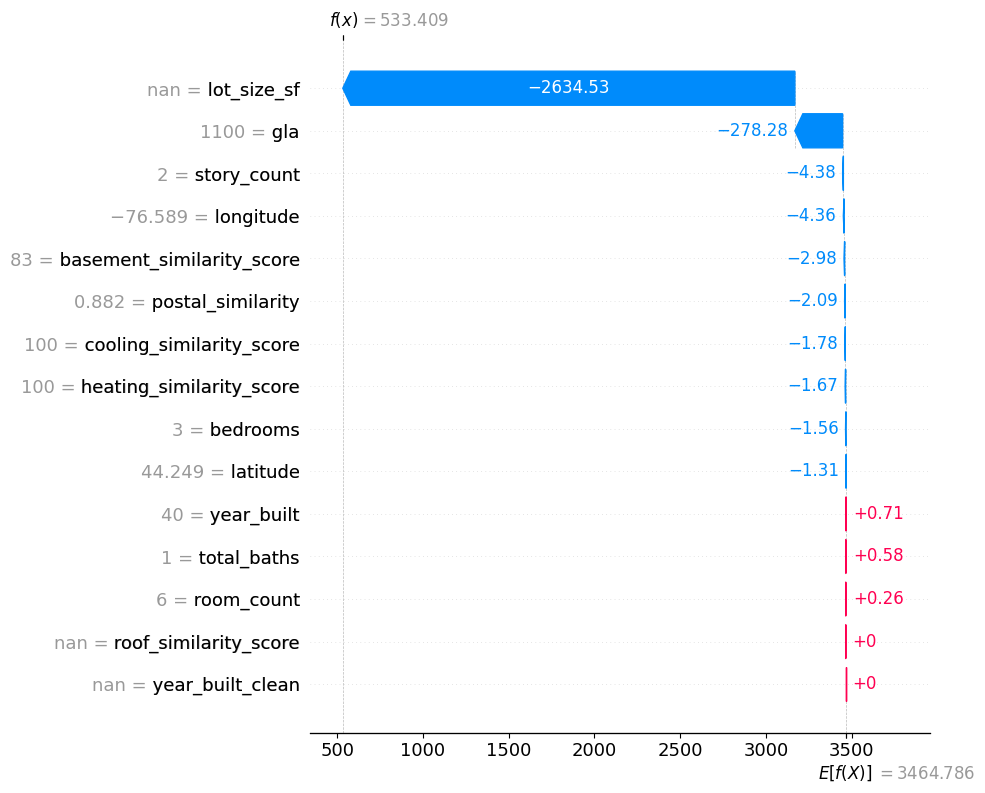


--- SHAP Explanation for Comp #2 ---


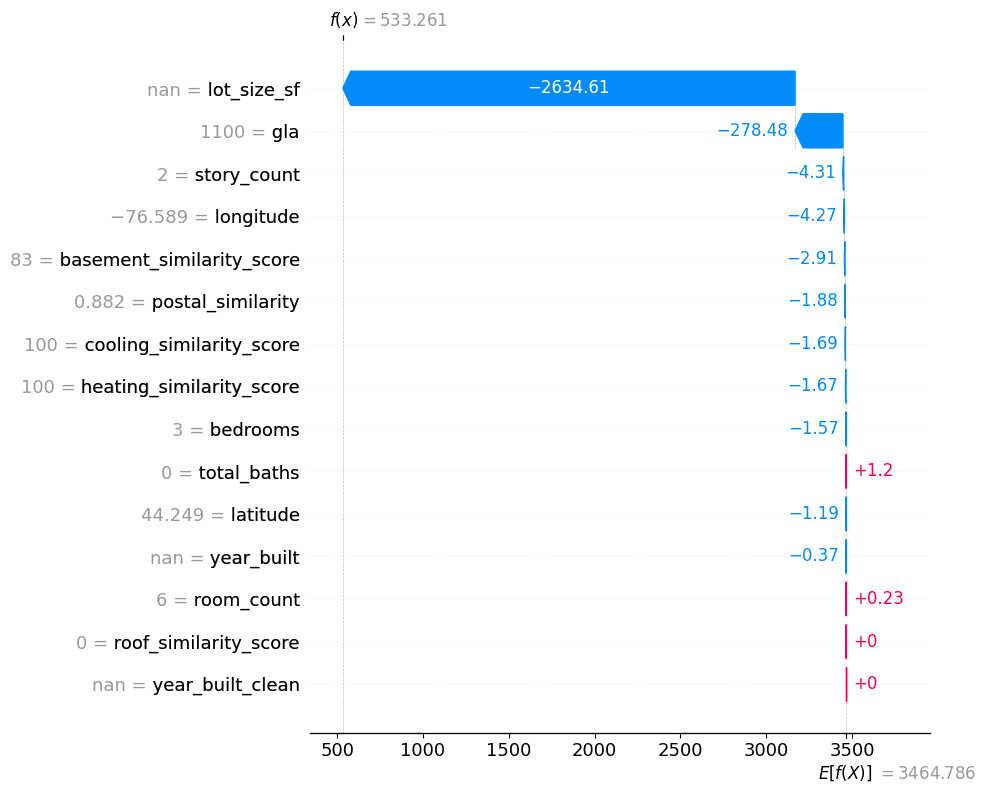


--- SHAP Explanation for Comp #3 ---


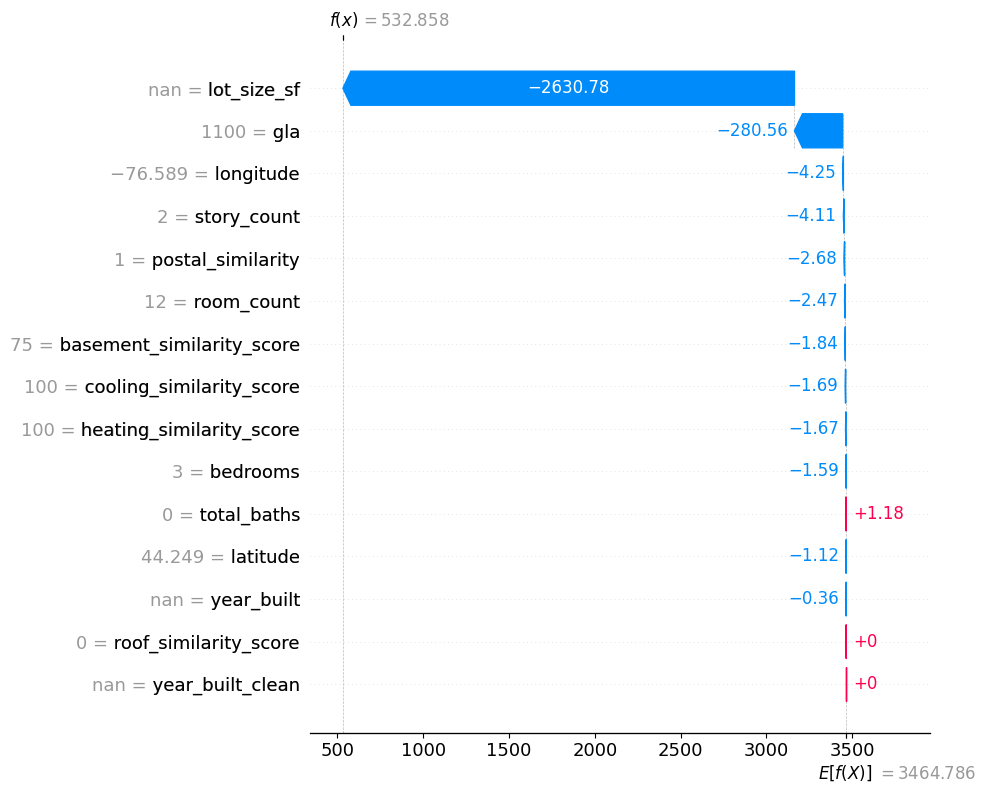

In [360]:
import shap

explainer = shap.Explainer(model, features)
top3 = X_train_sorted.head(3).drop(columns=['distance_to_subject'])
shap_values = explainer(top3)
for i in range(3):
    print(f"\n--- SHAP Explanation for Comp #{i+1} ---")
    shap.plots.waterfall(shap_values[i], max_display=len(features.columns))
